# Excel Workbook Analysis of Margin Call Value at Risk for Futures Contracts

## Background

Below I run an Excel workbook simulation in Python, using a worksheet borrowed from the Financial Engineering and Risk Management course provided by professors Martin Haugh and Garud Iyengar of the Industrial Engineering and Operations Research department at Columbia University. The margin calls on the worksheet titled `Simulated data` is based on simulated profits and losses (P&L) for corn futures.

Computing the P&L follows a simple formula, namely:
$$
    P_t = n_\text{pos}\times (P_t - P_{t-1})\times \frac{c}{100}
$$

where $n_\text{pos}$ is the number of outstanding positions in the portfolio and $c$ is the value of the contract (i.e., market value for a single bushel of corn). The vested target has a margin call whenever losses fall below the maintenance margin, in which case, the margin account is reset to the initial margin, and the vested target is expected to pay the difference in order for the margin account to return to initial margin.

With the pricing mechanic

$$
    P_{t} = P_{t - 1} + \sigma\times\text{CDF}^{-1}(\mathcal{N}(0, 1))
$$

I have a Brownian motion, because the price at $t$ depends on the price at $t-1$, but $P_{t}$ is also a martingale, due to normally-distributed increments based on the expression $\sigma\times\text{CDF}^{-1}(\mathcal{N}(0, 1))$.

## Apply a Random Seed for Reproducibility Purposes

## First Section of the Analysis

### Apply a Seed for Reproducibility Purposes

In [1]:
import numpy as np

np.random.seed(4640)

### In case I need to do something in Excel from within Python...

```python
from openpyxl import Workbook as wb, load_workbook

workbook = load_workbook(filename='C://Users//salma//Documents//Economics//Financial Economics//Financial Engineering//Columbia Course//Part I/Week3//cornfutures - swaptures.xlsx', read_only=True, data_only=True)

workbook['Sheet1']

wb_data = pd.ExcelFile(file)
ws_data = pd.read_excel(wb_data, index_col=None, na_values=['NA'], sheet_name='Simulated data')
ws_
ws_data.iloc[11:25, 6]
```

### The Workbook and Worksheet I need...

These is the `file_name` and `file_path` within my PC:

In [2]:
file_name = 'cornfutures - swaptures.xlsx'
file_path = 'C:\\Users\\salma\\Documents\\Economics\\Financial Economics\\Financial Engineering\\Columbia Course\\Part I\\Week3\\'

I begin by loading the Excel workbook into Python, where the `contract_value`, `initial_margin` of the margin account and `maintenance_margin`, required as per the contract with a broker dealer, are as follows. I then proceed with generating the data set.

In [3]:
import pandas as pd
import win32com.client

xl = win32com.client.DispatchEx('Excel.Application')
wb = xl.workbooks.open(file_path+file_name)

contract_value = wb.Sheets(2).Cells(3, 3).Value
initial_margin = wb.Sheets(2).Cells(4, 3).Value
maintenance_margin = wb.Sheets(2).Cells(5, 3).Value

d = {'Contract Value': contract_value,
     'Initial Margin': initial_margin,
     'Maintenance Margin': maintenance_margin}

X = pd.DataFrame({
         0: 1000*[0.0],
         1: 1000*[0.0],
         2: 1000*[0.0],
         3: 1000*[0.0],
         4: 1000*[0.0],
         5: 1000*[0.0],
         6: 1000*[0.0],
         7: 1000*[0.0],
         8: 1000*[0.0],
         9: 1000*[0.0],
        10: 1000*[0.0],
        11: 1000*[0.0],
        12: 1000*[0.0],
        13: 1000*[0.0],
        14: 1000*[0.0]
})

interest_rate = wb.Sheets(2).Cells(3, 8).Value
volatility = wb.Sheets(2).Cells(4, 8).Value

for i in range(0, 1000):
    wb.Sheets(2).Calculate()
    single_trial = pd.Series([wb.Sheets(2).Cells(i, 7).Value for i in range(13, 28)])
    X.iloc[i, :] = single_trial

**Note 01/21/2024**: I have since realizing my mistake under **Note 01/19/2024** decided to generate a general barplot for sampling distribution of size $1,000\times15$, for each of the $15$ days $\forall i \in [0,\dots,13,14]$.

<Figure size 640x480 with 0 Axes>

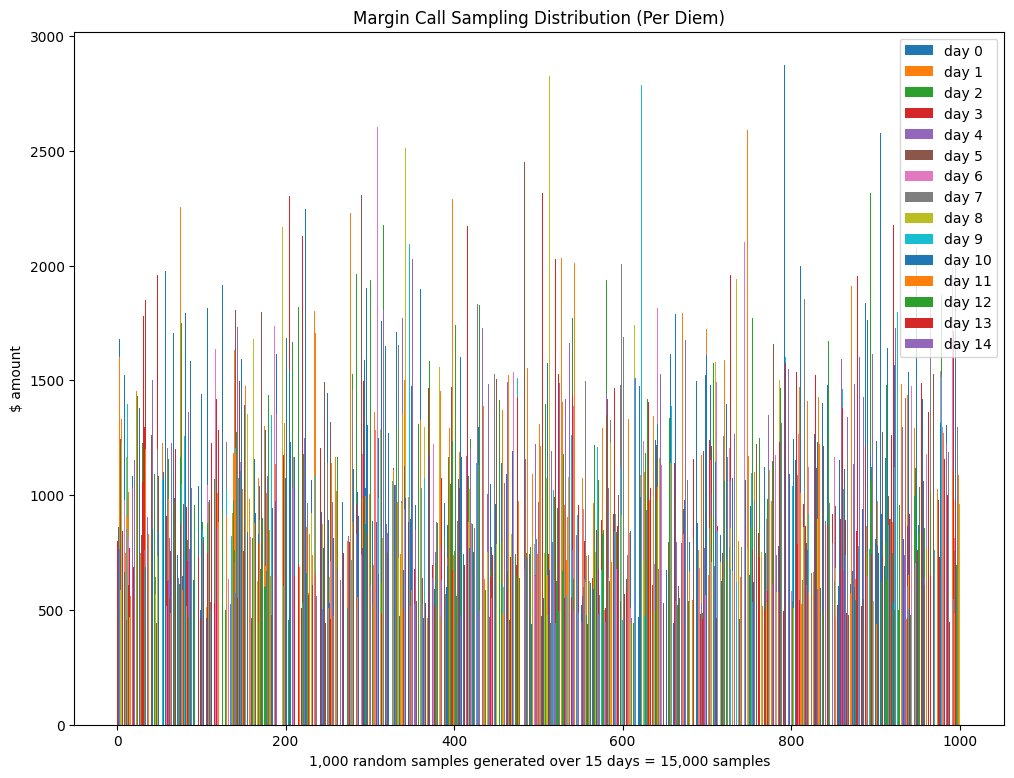

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for the bar plot
x = [X.iloc[:, i] for i in range(0, 15)]

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r = [np.arange(len(x[0])) + i * bar_width for i in range(15)]

plt.clf()
fig, ax = plt.subplots(1, 1)

# Create the bar plot
for i in range(len(x)):
    ax.bar(r[i], x[i], label='day ' + str(i))

# Add a title
ax.set_title('Margin Call Sampling Distribution (Per Diem)')

# Add a legend
ax.legend(loc='best')

# Label axes
ax.set_xlabel("1,000 random samples generated over 15 days = 15,000 samples")
ax.set_ylabel("\$ amount")

# Show the plot with the correct aspect ratio
fig.set_size_inches((12, 9))

I then generate barplots and histograms for the overall sampling distribution of size $1,000\times15$ over $15$ days. Please note how histograms and barplots generate two entirely different views of the data in question. An histogram gives a graphical representation of the margin call frequency that was generated for each of the $15$ days, whereas the barplot allows me to have a graphical representation of the sampling distribution of the amount due to a broker-dealer based on the margin call that was initiated at day $t \in [0,\dots,13,14]$. Since the margin call is $\$0$ most of the time in the histograms below, I remove entries with $\$0$.

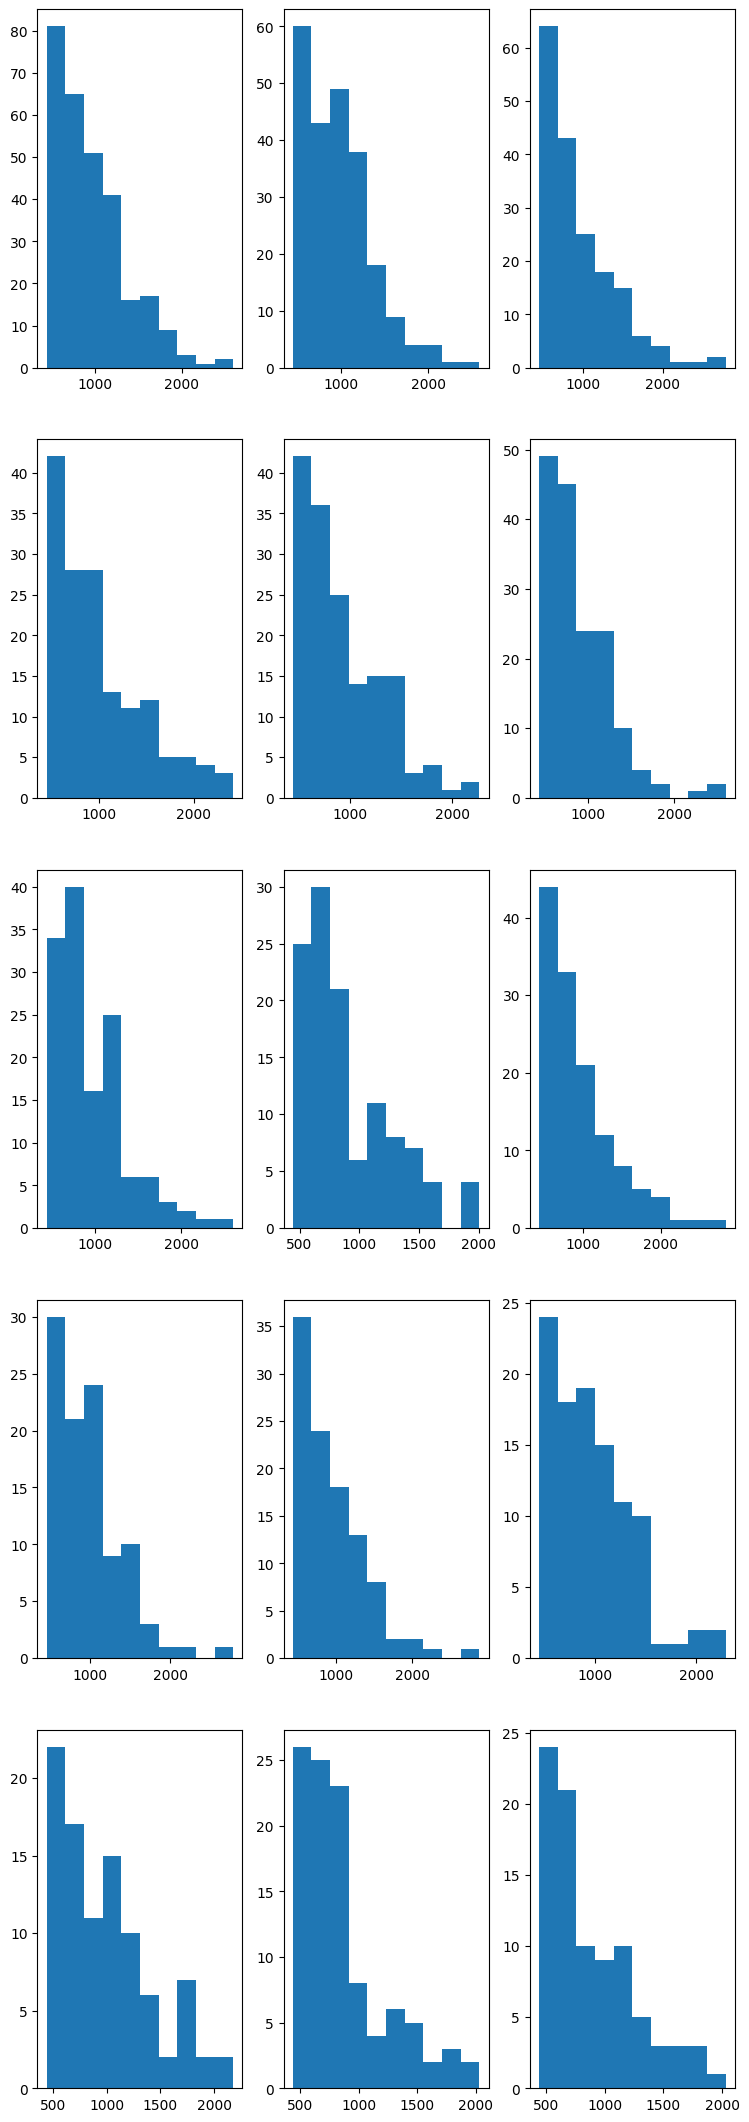

In [5]:
fig, axs = plt.subplots(5, 3)

count = -1
X_trimmed = X[X > 0]
for i in range(0, 5):
    for j in range(0, 3):
        count += 1
        if count == 15:
            break
        axs[i, j].hist(X_trimmed.iloc[:, count])

fig.set_size_inches(9, 27)

The histograms follow a random walk based on stochastic process $P_{t} = P_{t-1}+\delta\mathcal{Q}$, where $\mathcal{Q}\sim \text{CDF}^{-1}(\mathcal{N}(0,1))$ is a quantile that has risk-neutral probability based on $\mathcal{N}(0,1)$ and $\delta = \sigma$ is the scaling factor of the increments.

The process has normalization through independent and identically distributed martingale progression $k\delta\mathcal{Q}$, where $k$ is any stage within the progression, but it is still a Brownian motion (Bachelier, 1900), which is in stark contrast to the sampling distribution drawn beneath. It is important to note this contrast between frequency and sampling distributions for margin calls, where normalization reduces the risk factor in the sampling distribution of margin calls over time; this means that there are less margin calls as $t\rightarrow\infty$ (i.e., the margin call is essentially $\$0$ with higher frequency over time).

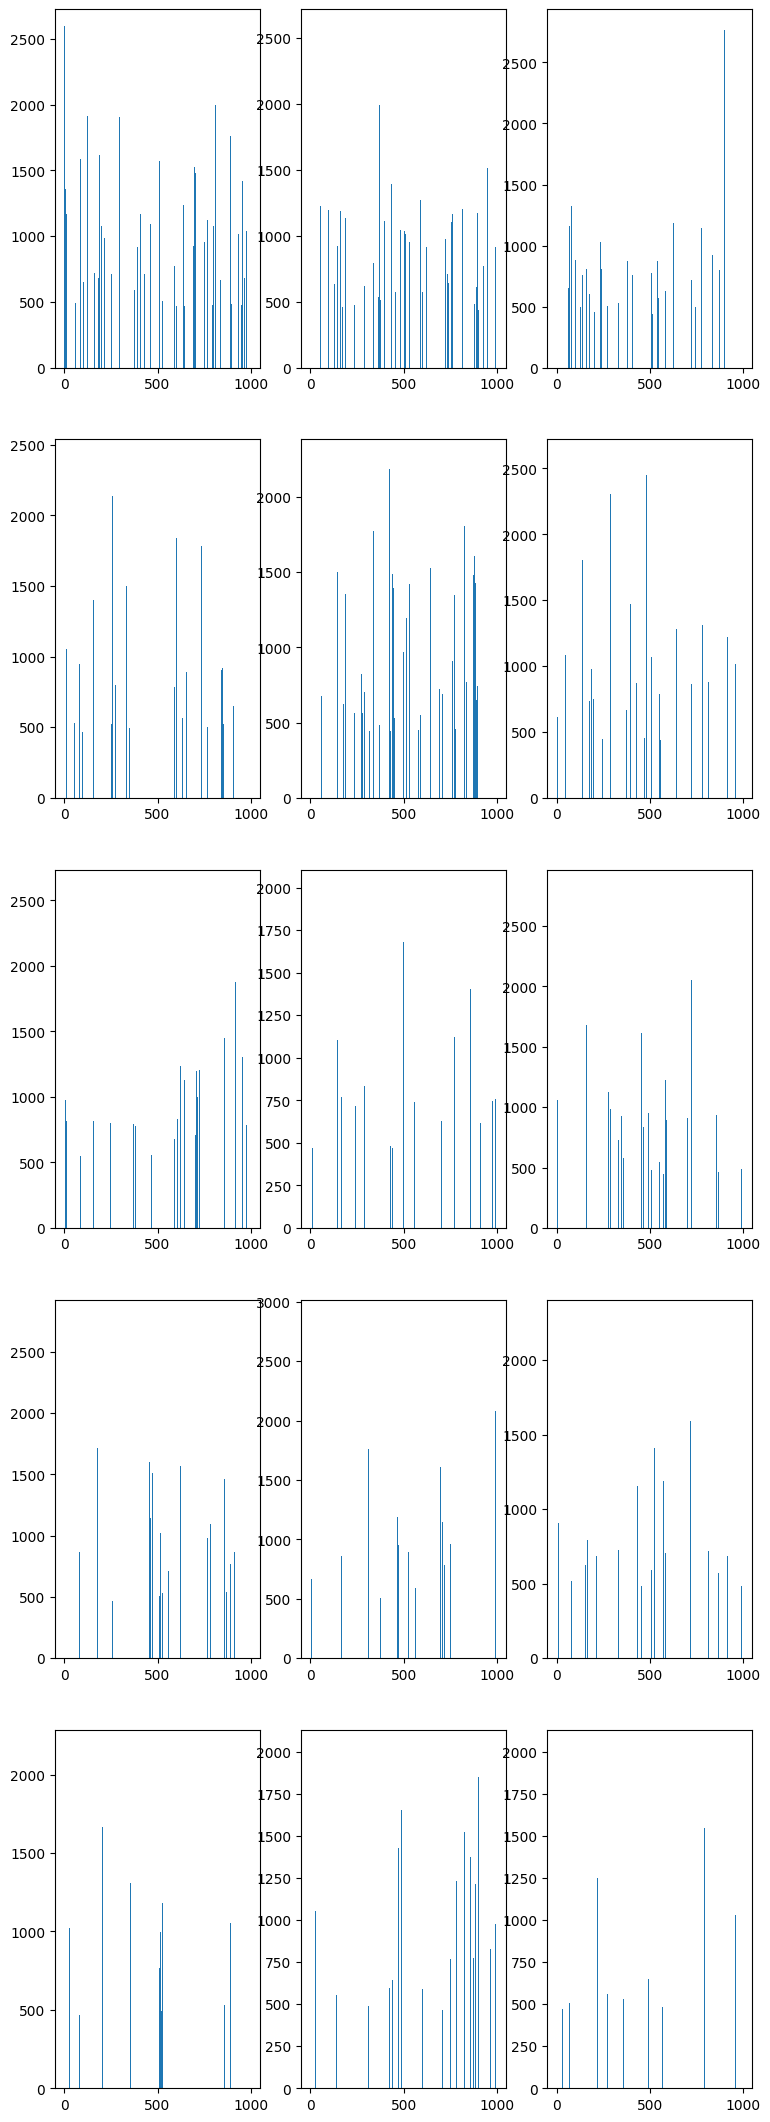

In [6]:
fig, axs = plt.subplots(5, 3)

count = -1
for i in range(0, 5):
    for j in range(0, 3):
        count += 1
        if count == 15:
            break
        axs[i, j].bar(X.index, X.iloc[:, count])

fig.set_size_inches(9, 27)

My take on the above graphics is that I have a **frequency distribution** that is positively skewed, whereas the **sampling distribution** is based on a progression with normally-distributed increments.

### Point Estimate of the Mean ($\mu$) and Standard Error of the Mean ($\epsilon(\mu)$)

The first thing I ask myself is whether or not I have an **ordinary arithmetic mean**. For the point estimates of the ordinary arithmetic mean, each observation has proportion $p_0 = \frac{1}{k}$. where the arithmetic mean then is $\mu\approx\text{E}[X] = \frac{1}{k}(x_1 + x_2 + \cdots + x_k)$, which is the average value of the sampling distribution, although later I will be gnerating statistical tests with unequal proportions across the days within a time series. The average value of a sampling distribution estimates its first order moment, such as mean, median or mode for a univariate parameter or mean differences and correlation for a bivariate or multivariate parameter. The point estimate is

$$^{\omega}\hat{\Theta}_i$$

where $\omega$ denotes an $\omega$-distributed variable, with an unknown population mean and population variance. There are four point estimates I will be taking beneath. One is for the **weighted arithmetic mean (WAM)** of a margin call ($x$), a second point estimate is for the standard deviation of margin call ($s$) and I take a third point estimate for the logarithmic returns in the margin account for the date range highlighted in the spreadsheet (between `Feb 22nd` and `March 15th`). There is a fourth point estimate for the standard deviation of the logirithmic returns.

### Computing Point Estimates and Standard Errors

**Note 01/31/2024**: I realized that the weighted arithmetic mean (WAM) is better in the case of margin calls.

**Note 01/22/2024**: I am making some corrections on my prior understanding regarding the standard error of the mean $\text{(SEM)}$, the standard deviation of the sample ($s$) and the standard deviation of the sampling distribution.

The standard error of $\mu$ is equal to the standard deviation of the sampling distribution. This is because the standard error of the mean

$\text{SEM}=\hat{\sigma}_{\bar{x}}\approx\frac{\sigma_x}{\sqrt{n}}$ or $\frac{s}{\sqrt{n}}$ which is conceptually similar, but not equal to the standard deviation of the sample, which is $s$,

and the standard deviation of the sampling distribution is the standard deviation of the distribution of sample means, used to estimate standard error of the population mean, and this is conceptually equal to the standard error of the mean or the $\text{SEM}$.

The standard deviation of the sample is a measure of variability

$s=\frac{\sqrt{\sum (x_i-\bar{x})^2}}{n-1}$.

$\therefore s\neq\text{SEM}=\frac{\sigma_{\bar{x}}}{\sqrt{n}} = \frac{s}{\sqrt{n}} = \text{standard deviation of the sampling distribution}$

I then have the following point estimates and corresponding standard errors, keeping in mind that the distribution of margin calls is proportional to the likelihood of having a positive margin call, for which I can take a trimmed, or to be more accurate, a weighted arithmetic mean, instead of the ordinary mean $\bar{x} = \frac{1}{n}x_1 + \frac{1}{n}x_2 + \cdots + \frac{1}{n}x_n$. In essence, I am taking the mean of $x \gt 0$ for $x \in X$.

The point estimate of $\bar{X}_w$ then becomes

$$
    \frac{<P, X>}{\sum_{i=1}^{n}p_i} = \frac{p_1x_1 + p_2x_2 + \cdots + p_nx_n}{\sum_{i=1}^n p_i} = \bar{X}_w = \frac{w_1x_1 + w_2x_2 + \cdots + w_nx_n}{w_1 + w_2 + \cdots + w_n} = \frac{<W, X>}{\sum_{i=1}^{n}w_i}, \forall p_i\ \text{or}\ w_i \in P\ \text{or}\ W, \forall x_i \in X
$$

to make an equivalence of proportions to the concept of using weights, which simplifies to

$$
    \bar{X}_w = \sum_{i=1}^{n}<w'_i, x_i>
$$

whenever $w'$ is a normalized set of weights

$$
    w'_i = \frac{w_i}{\sum_{j=1}^{n}w_j}
$$

but since I cannot normalize across a time-series of independent and identically distributed variables, the proportions will not be normalized. Also, I am keeping the ordinary arithmetic $\text{OAM}$ mean and the trimmed arithmetic mean or $\text{TAM}$ for analysis of skewness in the original, unweighted arithmetic mean.

In [187]:
import numpy as np
import pandas as pd
from scipy.stats import sem
from scipy.stats import trim_mean

p = []
μ = []
t = []
w = []
M = []
m = []
v = []
σ = []
u = []
R = []
q = []
r = []
ϕ = []

def log_tg_mean(ordinate_sample):
    """
    Calculates the tri-geometric mean of logarithmic returns.
    
    Args:
    log_returns: A NumPy array of logarithmic returns.
    
    Returns:
    The tri-geometric mean of the logarithmic returns.
    """
    
    if len(ordinate_sample) < 3:
        raise ValueError("Sample size must be at least three (3) for calculating TGM.")
    
    return np.exp(np.mean(np.log(1 + ordinate_sample)) / 3) - 1

def simple_tg_mean(ordinate_sample):
    """
    Calculates the tri-geometric mean of simple returns.
    
    Args:
    simple_returns: A NumPy array of simple returns.
    
    Returns:
    The tri-geometric mean of the simple returns.
    """
    
    if len(ordinate_sample) < 3:
        raise ValueError("Sample size must be at least three (3) for calculating TGM.")
    
    window_size = 3
    tgm = 1

    for i in range(window_size):
        if np.all(ordinate_sample[i:i+window_size] == 0):
            continue

        tgm *= np.cbrt(np.prod(ordinate_sample[i:i+window_size]))

    return tgm

n = 100
for i in range(0, 15):
    sample = np.random.choice(X.iloc[:, i], size=n, replace=True) # bootstrap a sample
    sample_mean = np.mean(sample) # unweighted arithmetic mean

    p.append(np.round(np.sum(sample > 0) / len(sample), 4)) # proportions rounded to three significant figures
    μ.append(sample_mean) # point estimate of μ
    t.append(trim_mean(sample, 0.1)) # trimmed mean
    
    sample = sample[sample > 0] # assigning positive sample values
    M.append(np.max(sample)) # maximum margin call in dollar amounts
    v.append(sem(sample)) # standard error of the mean
    σ.append(np.std(sample, ddof=1)) # standard deviation
    u.append(np.std(sample, ddof=1) / np.sqrt(np.sqrt(2*(n - 1)))) # standard error of the standard deviation

np.insert(R, 0, np.nan)
np.insert(r, 0, np.nan)

w = np.transpose(p)*μ
R = pd.Series(μ).pct_change().rolling(window=1).apply(lambda x: sum(x)) # simple returns
# q = pd.Series(R).rolling(window=2).apply(lambda x: np.std(x) / np.sqrt(np.size(x))) # standard error of simple returns
q = pd.Series(R).expanding().apply(lambda x: np.std(x) / np.sqrt(np.size(x))) # evolving standard error of simple returns
r = pd.Series(R).rolling(window=1).apply(lambda x: np.log(1 + float(pd.Series(x).iloc[0]))) # log returns
# ϕ = pd.Series(r).rolling(window=2).apply(lambda x: np.std(x) / np.sqrt(np.size(x))) # standard error of log returns
ϕ = pd.Series(R).expanding().apply(lambda x: np.std(x) / np.sqrt(np.size(x)))

g = pd.Series(R).rolling(window=3).apply(simple_tg_mean) # simple tri-geometric mean
h = pd.Series(r).rolling(window=3).apply(log_tg_mean) # log tri-geometric mean

m = [True if X.iloc[i, j] > 0 else False for i in range(len(X)) for j in range(len(X.iloc[0, :]))] # "true" proportions, which will be compared to sampled proportions later
m = np.reshape(m, (1000, 15)) # reshaping the "matrix" to 15 columns of 1,000 observations each
m = [np.sum(m[:, i]) / 1000 for i in range(0, 15)]

parms = pd.DataFrame({
            '%>0': p,
            'TPP': m,
            'OAM': μ,
            'TAM': t,
            'WAM': w,
            'MAX': M,
            'SEM': v,
            'STD': σ,
            'SES': u
}); parm2 = pd.DataFrame({
            'R':   R,
            'SER': q,
            'r':   r,
            'SEL': ϕ,
            'STG': g,
            'LTG': h
});

Note that the parameters under `parms` are for the sampling distribution of each independent and identically distributed variable $t\ \forall t \in [0, 14]$, and the parameters under `parm2` are for the time series. Below I am taking an Augmented-Dickey Fuller (ADF) to determine stationarity or trend stationarity in the $\text{WAM}$ across the time series. I then have hypotheses

$$
    \begin{cases}
        H_0: & \text{The time series has a unit-root and therefore is non-stationary.} \\
        H_a: & \text{The time series does not have a unit-root and therefore is stationary.}
    \end{cases}
$$

In [198]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(parms['WAM']) # performing ADF test

adf_stat = adf_result[0] # test statistic
p_value = adf_result[1] # p-value
lags = adf_result[2] # TS lags
n = adf_result[3] # number of observations
critical_values = adf_result[4] # critical values of the test

Given I have critical values

In [199]:
critical_values

{'1%': -4.01203360058309,
 '5%': -3.1041838775510207,
 '10%': -2.6909873469387753}

I identify the calculated test statistic at the $5\%$ confidence level for the $\text{ADF}$ test

In [200]:
adf_stat

-2.325082216652277

and based on the critical value for the $5\%$ level, I fail to reject $H_0$, meaning that the time-series of weighted arithmetic means is non-stationary.

$\bar{x}_t$ can be used as the **point estimate** for the first order moment $\mu_t$ of day $t$, but the data is heavily skewed towards the right, due to the frequency distribution of margin calls, which tend towards $\$0$, as per the barplots and histograms above, with infrequent positive margin calls, which is why the $\text{WAM}$ $^w\bar{x}_t$ reflects the underlying distribution better than the $\text{OAM}$.

$s$ can be used as the point estimate for the standard deviation of the bootstrapped sample, derived from a second order moment known as the sample variance, herein obtained via $1,000$ single trials of $15$ observations each, bootstrapping a sample of $100$. Note that these statistics apply to the sampling distribution of each day in the series and not across the time series. All sampling distributions have point estimates and standard errors as follows.

**sampling distribution parameters**

In [188]:
parms

,%>0,TPP,OAM,TAM,WAM,MAX,SEM,STD,SES
0,0.26,0.286,263.062064,139.589063,68.396137,2577.961501,102.160765,520.919733,138.868745
1,0.26,0.227,273.263805,158.888126,71.048589,2256.427351,80.795838,411.979552,109.827061
2,0.21,0.179,195.540477,77.743244,41.063500,2371.565704,113.854340,521.746130,139.089049
3,0.11,0.151,108.355620,5.789843,11.919118,1801.475560,123.842592,410.739412,109.496460
4,0.16,0.157,147.245494,42.025836,23.559279,1773.370439,94.663856,378.655426,100.943390
5,0.12,0.161,89.673157,11.386334,10.760779,1506.000525,101.365248,351.139520,93.608096
6,0.14,0.134,150.665530,31.884845,21.093174,2244.657924,129.706057,485.315626,129.377268
7,0.15,0.116,146.781877,33.454610,22.017282,1976.107536,137.864988,533.948801,142.342083
8,0.19,0.130,181.426684,60.386238,34.471070,2825.411686,130.745293,569.905520,151.927561
9,0.10,0.100,81.106510,0.000000,8.110651,1601.682111,139.456953,441.001606,117.563870


**time series parameters on a rolling window with their respective standard errors on an expanding window**

In [189]:
parm2

,R,SER,r,SEL,STG,LTG
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038781,0.000000,0.038048,0.000000,NaN,NaN
2,-0.284426,0.093302,-0.334670,0.093302,NaN,NaN
3,-0.445866,0.100748,-0.590349,0.100748,-0.065271,-0.130891
4,0.358910,0.138268,0.306683,0.138268,-0.137756,-0.108379
5,-0.390996,0.123582,-0.495930,0.123582,0.150856,-0.135458
6,0.680163,0.156235,0.518891,0.156235,0.258458,0.000048
7,-0.025777,0.135323,-0.026115,0.135323,0.014578,-0.032087
8,0.236029,0.122384,0.211904,0.122384,0.018113,0.067006
9,-0.552952,0.123427,-0.805088,0.123427,0.062384,-0.150643


I also take the $\text{TPP}$, which is the "$[\text{T}]$rue" $[\text{P}]$ro$[\text{P}]$ortion, as opposed to the estimated proportions $\text{\%>0}$. I will be examining the sampling error of using estimated proportions later on. From here onward, I will be expanding on the statistics generated above.

### Function for the Shape of the PDF and CDF: $μ$ and $σ$

What does the shape of the sampling distribution look like? What about the cummulative distribution?

In [ ]:
import matplotlib.pyplot as plt

def d(x, s):

    window = 15
    q1 = x.rolling(window, min_periods=1).apply(lambda x: np.percentile(x, 25))
    q3 = x.rolling(window, min_periods=1).apply(lambda x: np.percentile(x, 75))
    
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].bar(q1.index, q1, label='q1')
    axs[0, 0].bar(x.index, x, label='μ', bottom=q1)
    axs[0, 0].bar(q3.index, q3, label='q3', bottom=q1+x); axs[0, 0].set_title('q1, μ, and q3 pdf')
    # axs[0, 0].bar(parms['MAX'].index, parms['MAX'], label='max', bottom=q1+x+q3); axs[0, 0].set_title('q1, μ, q3 and max pdf')
    # q1, q3 = np.percentile(x, [25, 75])
    axs[0, 1].hist(x, bins=15, cumulative=True); axs[0, 1].set_title('μ cdf')
    axs[0, 2].boxplot(x); axs[0, 2].set_title('μ boxplot')
    
    axs[1, 0].bar(s.index, s); axs[1, 0].set_title('σ pdf')
    axs[1, 1].hist(s, cumulative=True); axs[1, 1].set_title('σ cdf')
    axs[1, 2].boxplot(s); axs[1, 2].set_title('σ boxplot')

    fig.legend(loc='upper left')
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.set_size_inches(9, 6)

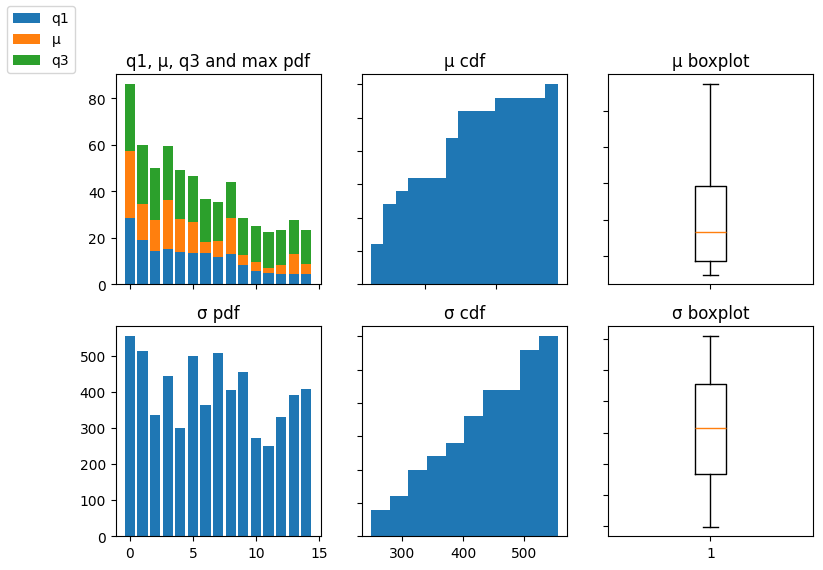

In [115]:
d(parms['WAM'], parms['STD'])

Removing the oultiers may be necessary for coming up with better estimates of first and higher order statistical moments, because the data is skewed. Keeping a required maintenance margin in the margin account with a broker-dealer adds a buffer so that most of the time there are no margin calls, and this makes the data positively skewed, along with adding normal increments to the Brownian motion of simulated prices.

### Function for Drawing Boxplots (Separately) and a Closer Look at Outliers

**01/19/2024 Note:** after reviewing the sampling distributions and experimental design, I learned that it is best to treat each date separately for the purpose of generating a parameter from the sampling distribution, which is known to be independent and identically distributed. This fixed the problem I was getting with outliers, although histograms and barplots are still important to have an overall sense of the data. Prior to doing bootstrapping, I should have taken a look at the barplot and histogram for the distribution of margin calls, which is based on Brownian pricing mechanic

$P_i = P_{i-1} + \sigma*\text{CDF}^{-1}{N(0, 1)}$

from which a broker-dealer determines the $\text{P\&L}$ and any margin call owed by any one of their clients. Earlier I determined that boxplots are not useful, due to high skewness in the data, although it is still useful to draw boxplots in order to illustrate the fact. Note that below I have a boxplot of the sampling distribution of each day in the series and not a boxplot of $\mu$, which is performed subsequently.

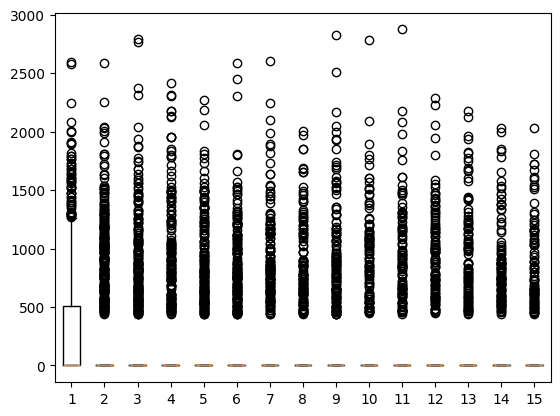

In [83]:
fig, ax = plt.subplots(1, 1)

ax.boxplot(X);

and the mode is

In [84]:
import statistics

statistics.mode(X)

0

A random walk is expected to be noisy and the nature of margin calls make the mode essentially $\$0$. This represents data that has substantial positive skewness, which means that many of the assumptions I had earlier were erroneous (such as assuming a t distribution when the distribution is heavily skewed), but the narrative for my analysis must continue.

Before performing any transformation or doing any computations on the data, I need to draw boxplots, computationally determine the Interquartile Range (IQR) for each of the first order moments, including returns on the margin calls for broker-dealers (labeled `r`), and what each parameter $^\omega\hat\Theta_i$ is, to remove outliers from the sampling distributions. My boxplots are determined by function `o` below,

In [85]:
def o(μ, ϵ, σ, r):
    fig = plt.figure(1, figsize=(0.6*20, 0.4*20))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.boxplot(μ); ax1.set_title('μ boxplot')
    ax2.boxplot(ϵ); ax2.set_title('ϵ boxplot')
    ax3.boxplot(σ); ax3.set_title('σ boxplot')
    ax4.boxplot(r); ax4.set_title('r boxplot')

which can be ran to determine outliers  for $μ$, $\epsilon$. $\sigma$ and $r$.

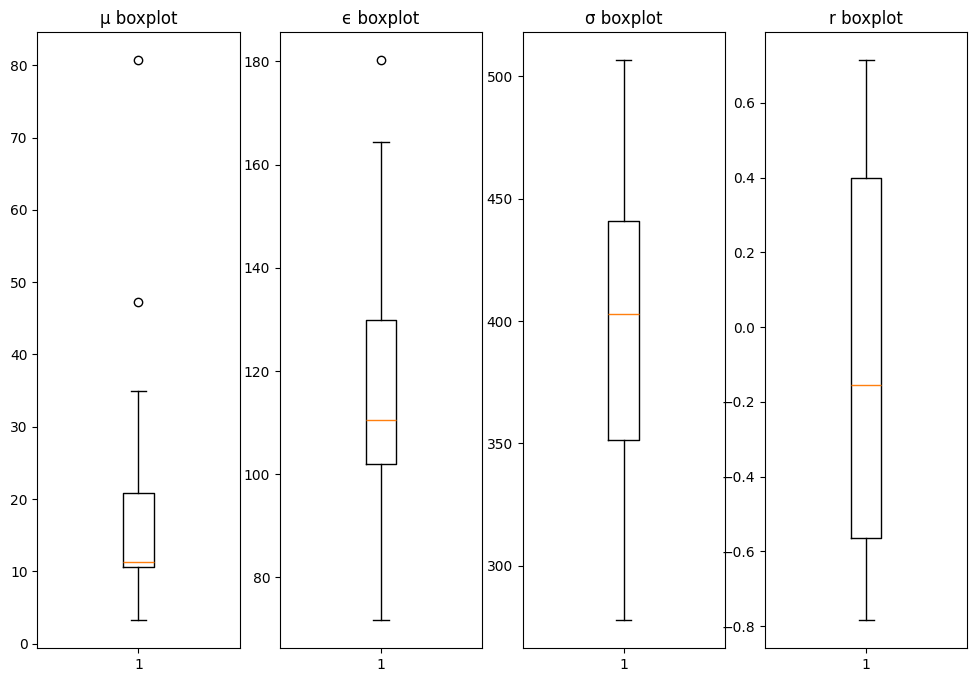

In [86]:
μ = parms['WAM']
ϵ = parms['SEM']
σ = parms['STD']
r = parms['r'][1:]

o(μ, ϵ, σ, r)

The sampling distributions of each first order moment has varying skewness. There is a problem with the parameter selection due to outliers. I will assume that there are outliers and take a Winsorized mean, to determine the `IQR` of each first order moment, as follows. The distribution is not normal.

In [87]:
q1_μ = np.percentile(μ, 25, method='midpoint')
q3_μ = np.percentile(μ, 75, method='midpoint')

q1_ϵ = np.percentile(ϵ, 25, method='midpoint')
q3_ϵ = np.percentile(ϵ, 75, method='midpoint')

q1_σ = np.percentile(σ, 25, method='midpoint')
q3_σ = np.percentile(σ, 75, method='midpoint')

q1_r = np.percentile(r, 25, method='midpoint')
q3_r = np.percentile(r, 75, method='midpoint')

iqr_μ = q3_μ-q1_μ;
iqr_ϵ = q3_ϵ-q1_ϵ;
iqr_σ = q3_σ-q1_σ;
iqr_r = q3_r-q1_r;

iqr_μ, iqr_ϵ, iqr_σ, iqr_r

(10.319499680354028, 27.92701592474785, 89.75460036503478, 0.8953741212367122)

which gives me a value range of

$$^\omega\hat{\Theta}_i \pm 1.5 * \text{IQR}$$

for $\mu$, $\epsilon$, $\sigma$ and $r$, as determined above.

**01/19/2023 Note:** I was updating the method I use for retrieving outliers, only to realize that retrieving outliers may not make much sense. I am not working with a sampling distribution here. I am working with a time series, and if I ever find a data point that diverges from the expected value by a substantial amount, I may need to consider other methods of dealing with these values. The most important question to ask myself is: am I working with **ordinate data** or is it **nominal data**? If I am working with ordinate data, updating so-called "outliers" by taking a Winsorized mean does not make an awful lot of sense. There may still be a reason to do it, but given that there is skewness in the underlying distribution, I need to consider alternatives.

I am only interested in the positive values for $\mu$, $\epsilon$ and $\sigma$, since these cannot be negative, but I am interested in both positive and negative values for $r$, since log returns can be positive or negative. This simplifies the procedure for getting Winsorized first order moments, which as per the following algorithm

In [88]:
outliers_μ = [np.mean(μ) - 1.5*iqr_μ, np.mean(μ) + 1.5*iqr_μ]
outliers_ε = [np.mean(ϵ) - 1.5*iqr_ϵ, np.mean(ϵ) + 1.5*iqr_ϵ]
outliers_σ = [np.mean(σ) - 1.5*iqr_σ, np.mean(μ) + 1.5*iqr_σ]
outliers_r = [np.mean(r) - 1.5*iqr_r, np.mean(μ) + 1.5*iqr_r]

for i, each in enumerate(μ):
    if each < outliers_μ[0]:
        μ[i] = outliers_μ[0]
    if each > outliers_μ[1]:
        μ[i] = outliers_μ[1]

for i, each in enumerate(ϵ):
    if each < outliers_ϵ[0]:
        ϵ[i] = outliers_ϵ[0]
    if each > outliers_ϵ[1]:
        ϵ[i] = outliers_ϵ[1]

for i, each in enumerate(σ):
    if each < outliers_σ[0]:
        each = outliers_σ[0]
    if each > outliers_σ[1]:
        each = outliers_σ[1]

for i, each in enumerate(r):
    if each < outliers_r[0]:
        r[i] = outliers_r[0]
    if each > outliers_r[1]:
        r[i] = outliers_r[1]

would generate the following box and whisker plots.

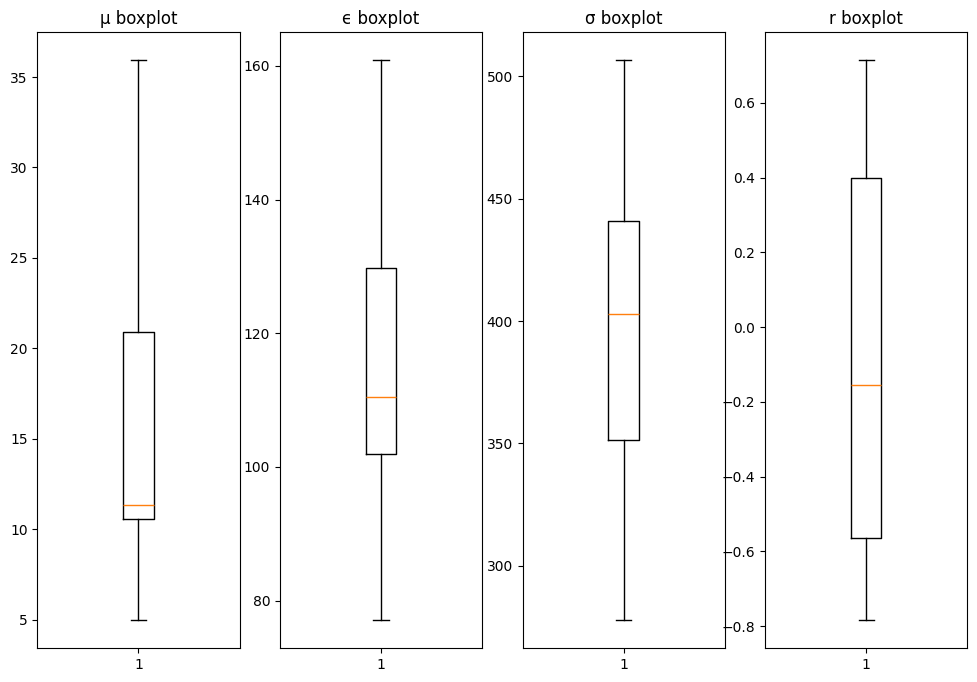

In [89]:
o(μ, ϵ, σ, r)

## Second Section of the Analysis

Before I continue, I need to reevaluate the *Winsorized* parameters for $\mu\epsilon\sigma r$, which have already been determined to be an average of the sampling distribution; every other parameter is derived from the original point estimate $\mu$, drawn through simple random sampling ($\text{SRS}$) and bootstrapping, with a slight Winsorized mean adjustment.

In [90]:
df = pd.DataFrame({
    "mean": μ,
    "sem": ϵ,
    "standard deviation": σ,
    "log returns": r
}); df

,mean,sem,standard deviation,log returns
0,35.924168,84.823251,448.842455,NaN
1,21.665183,77.059828,277.732530,-0.720177
2,35.924168,113.259603,506.512342,0.507322
3,10.969852,158.078579,447.113740,-0.612514
4,17.608685,105.900120,381.828313,0.031409
5,35.003093,108.767911,448.461585,0.435730
6,11.333580,110.523266,349.505254,-0.635190
7,6.072256,126.338045,357.337953,-0.423369
8,10.376412,94.021796,297.323025,0.335134
9,20.094136,97.888478,352.941927,0.419731


Considering the center of distribution based on the trigeometric mean, the margin calls resemble some sort of positive skewness for both `μ` and `σ` in the sampling distribution, and I cannot use the central limit theorem to obtain the parameters for first order moments $\hat{^\omega\Theta_i}$ in the per diem sampling distribution because it may require a sample size in the order of millions.

I may proceed with the following plots for $\mu$ and $\sigma$ time series, however. Note that the positive skewness in the sampling distribtuion persists even after using the tri-geometric mean, which is what would be expected from margin calls, where the median of the margin calls is still $\$0$ and there are infrequent positive margin calls. Something I will be doing later is to focus in on the tail-end of the margin call distribution for $15$ days, and I will assume that the sampling I performed earlier was the best I was able to achieve.

For the trigeometric mean (TGM), I have a lineplot as follows.

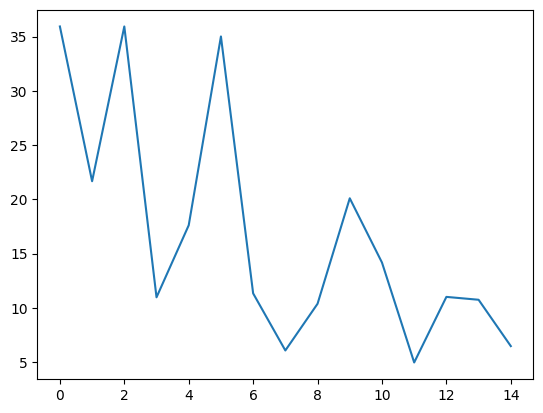

In [91]:
plt.plot(parms['WAM'])

and for the barplots and boxplots for $\mu$ and $\sigma$, I have

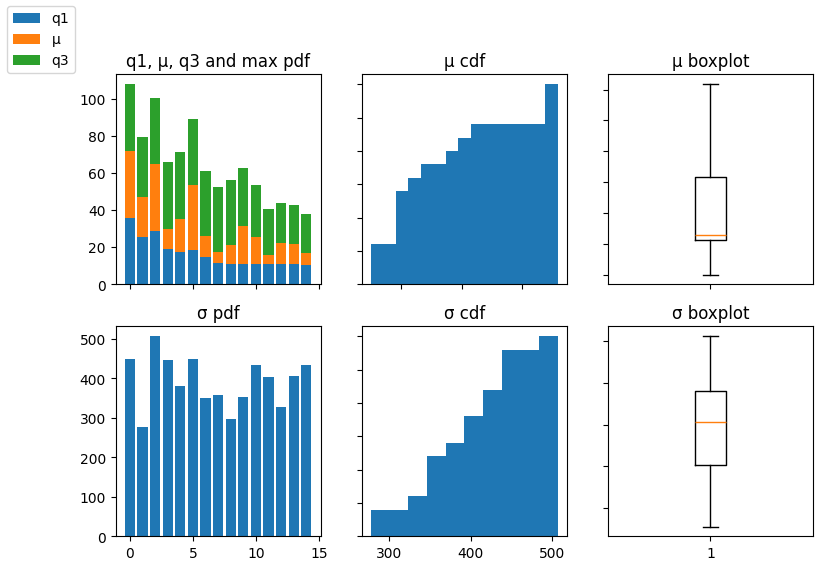

In [92]:
d(parms['WAM'], parms['STD'])

Note that the sampling distribtuion drawn in the first section of the analysis has central tendency relation: $\text{Mode} \leq \text{Median} \leq \text{Mean}$, due to positive skewness. The numeric value for $\hat{\mu}=\frac{1}{n}\sum_i\mu_i$ is

In [93]:
np.mean(μ)

16.822511314245176

and the numeric value for the median is

In [94]:
np.median(μ)

11.33357964774132

The mode is the most frequent value in the distribution or $0$ as was determined earlier under the `parms` table, where all $15$ days have a positive proportion that is strictly less than $50\%$ of values greater than $\$0$. It could be visually checked that the mode is smaller than the median, which is smaller than the mean.

The time series of the per diem mean margin calls has an expected value that is not normally distributed. A log-normal variable or binomial variable can make it even more complex, as in my example from the third section of the analysis, although I will keep with the theme of the analysis I had earlier, because it is important to keep a history of the work being done here. Assuming a $t$-distribution is wrong in the case of margin calls, because more often than not, there are no margin calls, as per the maintenance margin.

Calculating a tri-geometric mean of the sampling distribution, as I did above, helps with capturing the tail-end returns. The margin call log-returns of tri-geometric means are more accurate for modelling the margin call returns than using the mean $\mu$ log-returns of the margin calls if I want to scope into the tail-end of the sampling distribution.

Below, I scope into the log returns of sampled tri-geometric means, using a Pareto plot, which is the same mean generated in the stacked barplot above.

"\naxs[0, 2].bar(tm.index, np.cumsum(tm), color=color1)\naxs[0, 2].plot(tm, color=color2, marker='D'); axs[0, 2].set_title('Tri-Mean Pareto')\naxs[0, 2].yaxis.set_major_formatter(PercentFormatter())\n"

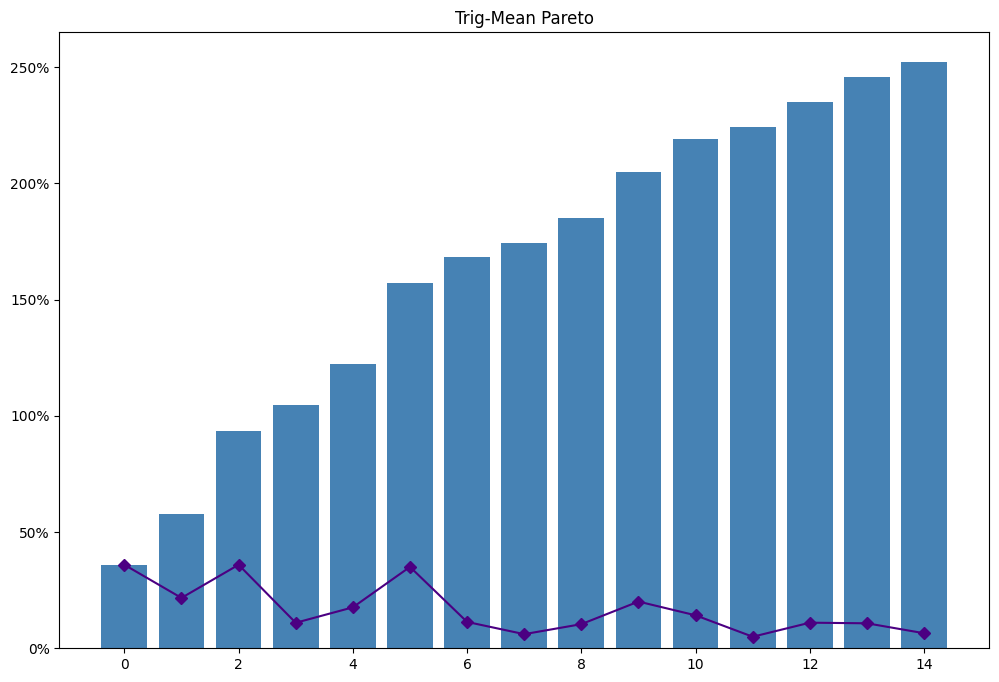

In [96]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

μ = parms['WAM']

color1='steelblue'
color2='indigo'

fig = plt.figure(1, figsize=(0.6*20, 0.4*20))
ax = fig.add_subplot(111)

ax.bar(μ.index, np.cumsum(μ), color=color1)
ax.plot(μ, color=color2, marker='D'); ax.set_title('Trig-Mean Pareto')
ax.yaxis.set_major_formatter(PercentFormatter())

'''
axs[0, 2].bar(tm.index, np.cumsum(tm), color=color1)
axs[0, 2].plot(tm, color=color2, marker='D'); axs[0, 2].set_title('Tri-Mean Pareto')
axs[0, 2].yaxis.set_major_formatter(PercentFormatter())
'''

Day number seven ($7$) above has the smallest expected value of the log returns as per the Pareto lineplot

As can be seen in the plot above, the returns are fairly stable throughout the series, as per the margin call log-returns of tri-geometric means of daily sampling distribtuions.

However, it is important to keep in mind that a more accurate representation of what I had earlier in the `parms` table, where the nonzero proportions exhibit deminishing returns, and this would yield a more complete picture, as the Pareto plot applies to nonzero margin call returns of the tri-geometric mean of daily sampling distributions.

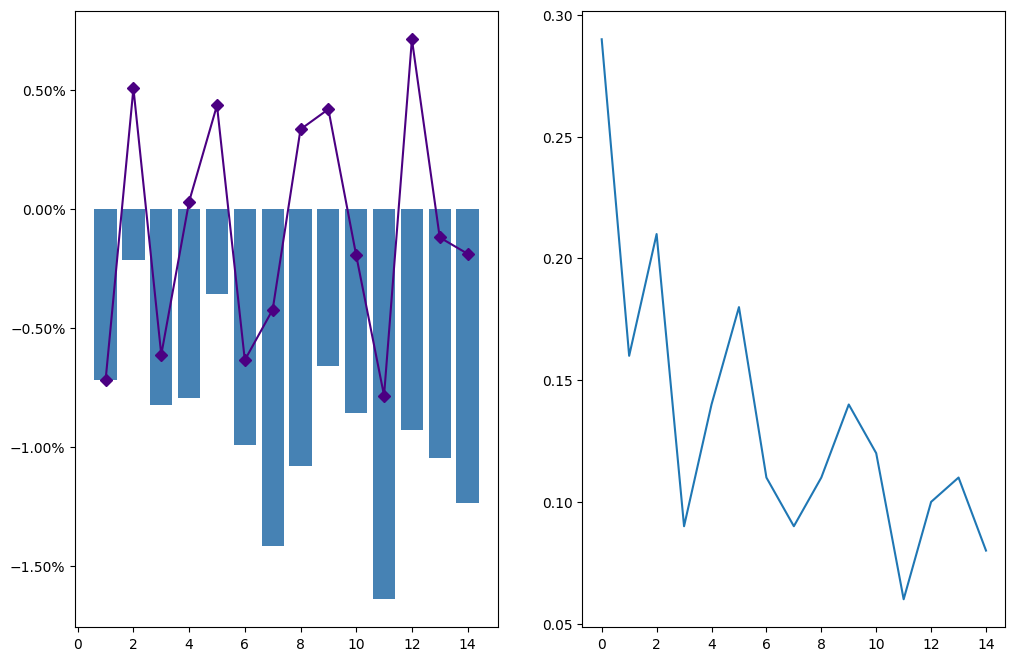

In [97]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


props = parms['%>0']

fig = plt.figure(1, figsize=(0.6*20, 0.4*20))

ax1 = fig.add_subplot(121)
ax1.bar(r.index, np.cumsum(r), color=color1)
ax1.plot(r, color=color2, marker='D'); ax.set_title('Trig-Mean Pareto')
ax1.yaxis.set_major_formatter(PercentFormatter())

ax2 = fig.add_subplot(122)
ax2.plot(props.index, props)

### Reliability Factors

**01/24/2024 Note:** t-value testing does not work, but I am keeping these results to retain the history of my empirical analysis, and for this purpose alone, I explain why t-value testing does not work when analyzing simulated margin calls.

T values found [here](https://www.tdistributiontable.com/).

$$t_{\alpha}\text{ or }z_{\alpha}$$

The reliability factor is equivalent to the kernel density score used to compute confidence intervals. For my analysis, I am considering reliability factors for the $90\%$, $95\%$, $97.5\%$ and the $99\%$ confidence intervals for $\text{df} = n-1 = 14$ degrees of freedom on a Gosset t-statistic.

In [98]:
conf_int = ['90%', '95%', '97.5%', '99%']
conf_int_values = ['1.345', '1.761', '2.145', '2.624']

c_ints = {'conf_int': conf_int, 'conf_int_values': conf_int_values}

rf = pd.DataFrame(c_ints)
rf

,conf_int,conf_int_values
0,90%,1.345
1,95%,1.761
2,97.5%,2.145
3,99%,2.624


Here I am using the $(1-\alpha) = 95\%$ confidence level, for $\alpha = 5\%$ (useful for a one-tailed hypothesis test) and $\frac{\alpha}{2} = 2.5\%$ (useful for a two-tailed hypothesis test).

### Quick Self-Tip

If I wanted to calculate the critical t-values, instead of looking into a table, I can use the following `scypi` function in Python with $\text{df} = 14$. This would avoid many mistakes with having to interpolate critical values whenever it is not found in a $t$-table.

In [99]:
from scipy.stats import t

t.ppf(0.95, df = 14)

1.7613101357748562

### Standard Error

**01/24/2024 Note:** The standard error of the mean is replaced with the standard error of the log-returns of tri-geometric means. I have further updated the method of retrieving the standard error, taking into consideration that I am working with ordinate data and not nominal data, for which the standard error would be

$$\text{SE} = \frac{s_i}{\sqrt{n}}$$

or

In [100]:
window = 15

def trig_r(x):
    pos = x[x > 0] # filter positive
    w = len(pos) / len(x) # proportion of positive log returns
    g = np.exp(np.mean(np.log(pos))) # geometric mean of pos log returns
    return w * g + (1 - w) * 0

s1 = μ
se_μ = pd.Series(s1).rolling(window=1).apply(lambda x: [x] / np.sqrt(np.size(x)))
# se_μ = s1 / np.sqrt(np.size(s1))

s2 = ϵ
se_ϵ = pd.Series(s2).rolling(window=1).apply(lambda x: [x] / np.sqrt(np.size(x)))
# se_ϵ = s2 / np.sqrt(np.size(s2))

s3 = σ
se_σ = pd.Series(s3).rolling(window=1).apply(lambda x: [x] / np.sqrt(np.size(x)))

s4 = r
se_r = pd.Series(s4).rolling(window=1).apply(lambda x: [x] / np.sqrt(np.size(x)))

df = pd.DataFrame({'se_μ': se_μ, 'se_ϵ': se_ϵ, 'se_σ': se_σ, 'se_r': se_r}); df

,se_μ,se_ϵ,se_σ,se_r
0,35.924168,84.823251,448.842455,NaN
1,21.665183,77.059828,277.732530,-0.720177
2,35.924168,113.259603,506.512342,0.507322
3,10.969852,158.078579,447.113740,-0.612514
4,17.608685,105.900120,381.828313,0.031409
5,35.003093,108.767911,448.461585,0.435730
6,11.333580,110.523266,349.505254,-0.635190
7,6.072256,126.338045,357.337953,-0.423369
8,10.376412,94.021796,297.323025,0.335134
9,20.094136,97.888478,352.941927,0.419731


The per-diem sampling distributions are nominal data. The margin call log-returns of the tri-geometric means is ordinate data. Therefore, the standard error should reflect the ordinate nature of log-returns. I then have the following line plots.

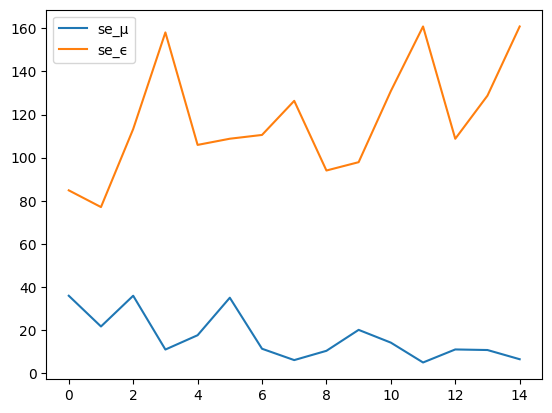

In [101]:
ax = plt.subplot()

ax.plot(df['se_μ'], label='se_μ')
ax.plot(df['se_ϵ'], label='se_ϵ')
ax.legend(loc='upper left')

### Hypothesis Testing for 5% Value at Risk

Had the distribution been normal, a $5\%$ value at risk would have given me how much money I will lose with $95\%$ confidence in a one-tailed test, piece-wise defined as follows.

$$
    \begin{cases}
        H_0 & \Theta \leq \Theta_0 \\
        H_a & \Theta \gt \Theta_0
    \end{cases}
$$

where $\Theta = r$ and $\Theta_0 = r_0$ for this example. Let us say the hypothesized value is $11\%$ return, so $r_0 = 0.11$. I can then calculate the t-statistic for the first order moment $r$, which is

$$
    t = \frac{\bar{r}-{r_0}}{s/\sqrt{n}}
$$

or

In [102]:
t = np.abs((s4 - 0.11)) / df['se_σ']; t

0          NaN
1     0.002989
2     0.000784
3     0.001616
4     0.000206
5     0.000726
6     0.002132
7     0.001493
8     0.000757
9     0.000878
10    0.000702
11    0.002219
12    0.001851
13    0.000564
14    0.000686
dtype: float64

and the critical value at the $5\%$ level of significance was determined to be $1.761$. Critical t-values fall within the confidence region.

$\therefore$, I fail to reject the null hypothesis ($H_0$) at the $95\%$ level in favor of the alternative ($H_a$); this means that there is sufficient evidence to suggest that $r \leq 0.11$ for the "buy and hold" strategy for one position at the $95\%$ level.

**01/24/2024 Note:** There is positive skewness in the data, which means that t-value testing is inaccurate, which goes back to what I nserted up there: "had the distribution been normal."

### Confidence Intervals

Putting it all together, I have

$$\text{CI} = \text{PE} \pm \text{RF}\times \text{SE}$$
$$\text{CI} = \bar{X} \pm t_{\alpha}\times\frac{s}{\sqrt{n}}$$

where $s$ is equal to the sampling distribution of $\phi$, the standard deviation of the returns, as a derivation from the second order variance, and $n$ is the number of observations in the sampling distribution of $\phi$.

In [103]:
ci = (r-float(rf['conf_int_values'][0])*se_r, r+float(rf['conf_int_values'][1])*se_r)
ci

(1     0.248461
 2    -0.175026
 3     0.211317
 4    -0.010836
 5    -0.150327
 6     0.219141
 7     0.146062
 8    -0.115621
 9    -0.144807
 10    0.067221
 11    0.270545
 12   -0.246247
 13    0.041281
 14    0.064916
 Name: r, dtype: float64,
 1    -1.988408
 2     1.400717
 3    -1.691151
 4     0.086720
 5     1.203050
 6    -1.753759
 7    -1.168922
 8     0.925306
 9     1.158877
 10   -0.537962
 11   -2.165145
 12    1.970689
 13   -0.330367
 14   -0.519517
 Name: r, dtype: float64)

### 5% Value-at-Risk (VaR) [Parametric Method]

Suppose $\$5,000$ is deposited, or the full contract value of a single position in the underlying commodity (corn, in this case). How much of these $\$5,000$ is put at risk by using futures contract, with initial margin $\$1,688$ and maintenance margin $\$1,250$?

In [104]:
5000*(r+se_r*float(rf['conf_int_values'][1]))

1     -9942.038251
2      7003.586081
3     -8455.756141
4       433.597652
5      6015.249221
6     -8768.797476
7     -5844.610424
8      4626.529016
9      5794.383907
10    -2689.807944
11   -10825.724623
12     9853.446126
13    -1651.832629
14    -2597.586648
Name: r, dtype: float64

With $95\%$, the value at risk for a single position is as calculated above. In the below section, I extend the single position contract into a contract involving incremental positions.

## Third Section of the Analysis

**01/27/2024 Note:** I have learned that the tri-geometric mean does not apply for nominal data, such as the sampling distributions I had earlier for $\text{sample of }1,000 \text{ experimental observations} \times 15\text{ days}$, but tri-geometric mean is useful for modeling the tail-end of a distribution of margin call returns.

The proportions of positive margin calls is also important to consider, as I then have the following inner product data matrix sampling distributions $x_i$ with proportions $p_i$.

$^+\bar{x}_i = <p_i, x_i> = p_i^tx_i = \sum_{i=1}^{n}p_ix_i$ for positive proportions of margin call returns.

In this third section of the analysis, I will be studying the value at risk for various positions on a single commodity, namely, bushels of corn, where according to the exercise, one bushel of corn has a contract value of $5,000$ and $\frac{\text{no}}{100}$ dollars. I will be incrementally increasing the positions, to model a corn trader taking the decision to buy extra bushels of corn (up to 10 at a time) or hold the current position, based on the binomial variabnle $X \sim \text{Bin}(n, p)$ with probability mass function

$$
    f(k, n, p) = P(k; n, p) = Pr(X = k) = \binom{n}{k}p^k(1 - p)^{n - k}
$$

and cummulative distribution function

$$
    F(r; k \leq r \leq n) = \sum_{k=0}^{r} \binom{n}{k}p^k(1 - p)^{n - k}
$$

where I am sampling using the following probability vector for the position increments, starting at $1$ for day $1$, over $14$ days

$$
    P = \frac{1}{100}(37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03)^t
$$

which, after taking these increments, gives me the following asset positions.

In [64]:
pos = [1]
countdown = 14

probs = np.random.binomial(n=10, p=(1/100)*np.transpose([37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03]))

i = 1
while countdown > 0:
    countdown -= 1
    pos.append(pos[i-1] + probs[i-1]); i += 1

pos

[1, 6, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

Now to do the fun part, which is to modify the worksheet, using a "buy and hold" strategy for each new positions obtained during the $15$ consecutive days.

In [65]:
for i, x in enumerate(range(12, 27)):
    wb.Sheets(2).Cells(x, 4).Value = pos[i]

Here are the point estimates for $μ$, $\epsilon$ and $σ$ as well as $r$, and their respective standard errors (reworking an analysis I made earlier):

In [98]:
import numpy as np
import pandas as pd
from scipy.stats import sem
from scipy.stats import trim_mean

μ = []
g = []
h = []
t = []
M = []
v = []
s = []
u = []
R = []
r = []

def log_tg_mean(ordinate_sample):
    if len(ordinate_sample) < 3:
        raise ValueError("Sample size must be at least three (3) for calculating TGM.")
    
    return np.exp(np.mean(np.log(ordinate_sample + 1)) / 3) - 1

def simple_tg_mean(ordinate_sample):
    """
    Calculates the tri-geometric mean of simple returns.
    
    Args:
    simple_returns: A NumPy array of simple returns.
    
    Returns:
    The tri-geometric mean of the simple returns.
    """
    
    if len(ordinate_sample) < 3:
        raise ValueError("Sample size must be at least three (3) for calculating TGM.")
    
    window_size = 3
    tgm = 1

    for i in range(window_size):
        if np.all(ordinate_sample[i:i+window_size] == 0):
            continue

        tgm *= np.cbrt(np.prod(ordinate_sample[i:i+window_size]))

    return tgm

n = 100
for i in range(0, 15):
    sample = np.random.choice(X.iloc[:, i], size=n, replace=True) # bootstrap a sample
    sample_mean = np.mean(sample)
    μ.append(pos[i]*sample_mean) # point estimate of μ
    t.append(pos[i]*trim_mean(sample, 0.1))
    
    sample = sample[sample > 0] # assigning positive sample values
    M.append(pos[i]*np.max(sample)) # maximum margin call in dollar amounts
    v.append(pos[i]*sem(sample)) # standard error of the mean
    s.append(pos[i]*np.std(sample)) # standard deviation
    u.append(pos[i]*np.std(sample, ddof=1) / np.sqrt(np.size(sample))) # standard error of the standard deviation

np.insert(R, 0, np.nan)
R = pd.Series(μ).pct_change().rolling(window=1).apply(lambda x: sum(x)) # simple returns

np.insert(r, 0, np.nan)
r = pd.Series(R).rolling(window=1).apply(lambda x: np.log(1 + pd.Series(x).iloc[0])) # log returns

n = len(g)
q = np.std(R) / np.sqrt(np.size(R)) # standard error of simple returns
w = np.std(r) / np.sqrt(np.size(r)) # standard error of log returns

g = pd.Series(R).rolling(window=3).apply(simple_tg_mean)
h = log_tg_mean(r)

m = [True if X.iloc[i, j] > 0 else False for i in range(len(X)) for j in range(len(X.iloc[0, :]))]
m = np.reshape(m, (1000, 15))
p = [np.sum(m[:, i]) / len(m) for i in range(len(m[0, :]))]

parms = pd.DataFrame({
            'AM': μ,
            'TM': t,
            'TGM': g,
            'MAX': M,
            'SEM': v,
            'STD': s,
            '$\epsilon$(σ)': u,
            'R': R,
            'r': r,
            '%>0': p
}); parm2 = pd.DataFrame({
            'standard error of R': [q],
            'standard error of r': [w]
});

with `parms`

In [99]:
parms

,AM,TM,TGM,MAX,SEM,STD,$\epsilon$(σ),R,r,%>0
0,234.832542,120.890712,NaN,1996.695941,88.710627,425.441223,88.710627,NaN,NaN,0.295
1,1859.198907,1033.432791,NaN,13496.907807,613.474990,3128.120945,613.474990,6.917126,2.069028,0.231
2,2980.445777,1936.824870,NaN,25224.450019,804.470378,4479.101504,804.470378,0.603081,0.471927,0.208
3,1233.045528,338.518090,-0.797389,13277.255881,708.600729,2651.341152,708.600729,-0.586288,-0.882586,0.144
4,1650.925323,326.596586,0.200573,28080.024729,1801.737358,6496.256430,1801.737358,0.338901,0.291849,0.153
5,1498.969869,465.121437,0.037446,18033.442174,1005.756367,4023.025470,1005.756367,-0.092043,-0.096558,0.166
6,1303.885366,186.431434,-0.018498,21837.259458,1449.219309,5020.242949,1449.219309,-0.130146,-0.139430,0.115
7,815.581740,0.000000,0.043424,16067.012479,1324.819888,3505.143956,1324.819888,-0.374499,-0.469202,0.121
8,729.640750,0.000000,0.027744,14937.819577,1291.883293,3653.997749,1291.883293,-0.105374,-0.111349,0.106
9,1505.297982,418.477250,-0.170949,19831.280646,1163.147653,4504.851490,1163.147653,1.063067,0.724194,0.116


and standard error of returns

In [100]:
parm2

,standard error of R,standard error of r
0,0.471415,0.175798


Here are replotted graphics for the boxplots.

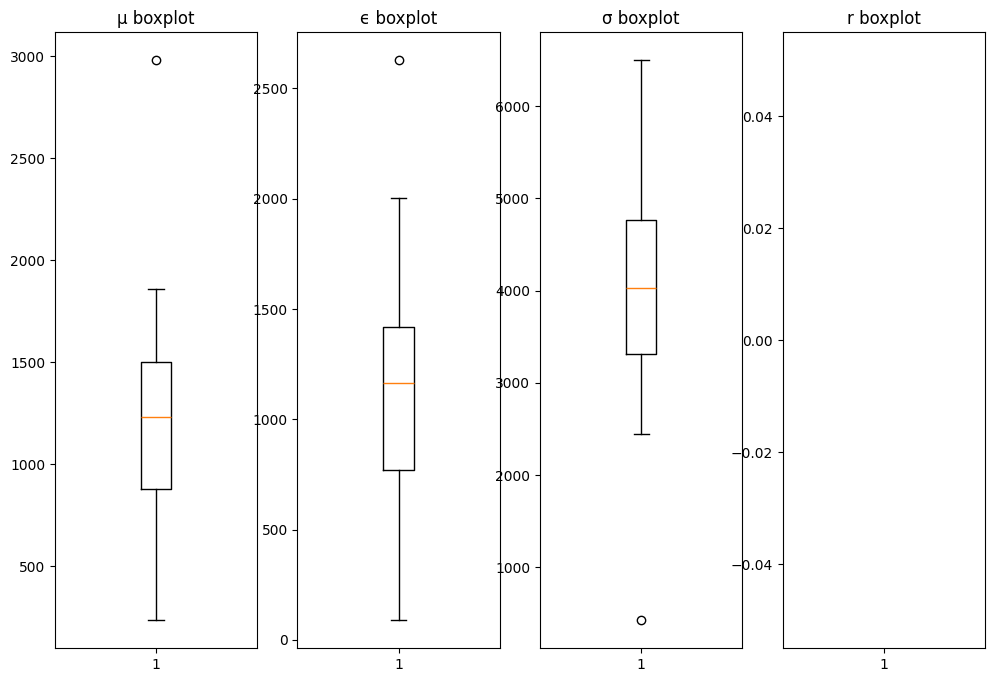

In [104]:
μ = parms['AM']
ϵ = parms['SEM']
σ = parms['STD']
r = parms['r']

o(μ, ϵ, σ, r)

In this particular case, the standard errors are higher, as would be expected from incrementally adding positions to the existing portfolio. I do the same as before for the plots.

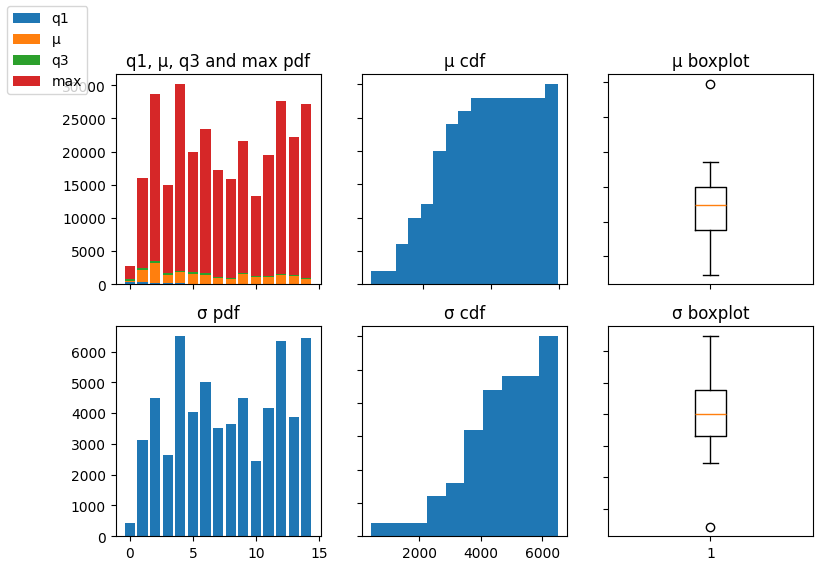

In [106]:
d(parms['MAX'], parms['AM'], parms['STD'])

### A More Appropriate Approach to Measuring the Central Tendency of a Skewed Distribution

As has been evident up and until now, margin calls can happen at any time, but it is more likely than not that there is no margin call. These values are never negative, but a common caveat would be when obtaining log returns, where there would be negative returns, which added to the skewness in the data (the skewness is a third-order statistical moment which measures deviation from the center of mass), does not make an estimate based on the mean appropriate. The median is not appropriate either, because it is likely to be zero. I then have it that

In [107]:
import pandas as pd, numpy as np
from scipy.stats import trim_mean, mstats

def modified_b():
    
    def rolling_volatility(log_returns, window_size):
        return pd.Series(log_returns).rolling(window_size, min_periods=1).std()
    
    rvol = rolling_volatility(r[1:], 14); rvol = rvol[1:]
    
    color1 = 'teal'
    color2 = 'indigo'
    color3 = 'maroon'
    
    # assume simple returns for below function
    def trimean(x):
        q1, median, q3 = mstats.mquantiles(x, [0.25, 0.5, 0.75])
        return (q1 + 2*median + q3) / 4
    
    def quartile_mean(x):
        q1, q3 = np.percentile(x, [25, 75])
        return (q1 + q3) / 2
    
    window = 14
    tm = rvol.rolling(window, min_periods=1).apply(trimean)
    
    window = 14
    qm = rvol.rolling(window, min_periods=1).apply(quartile_mean)
    
    dz = pd.DataFrame({
        'qm': qm,
        'tm': tm
    })
    
    fig, axs = plt.subplots(1, 2)
    axs[0].bar(qm.index, dz['qm'], label='qm', color=color1)
    axs[0].bar(tm.index, dz['tm'], bottom=dz['qm'], label='tm', color=color2)
    
    axs[1].plot(np.subtract(tm, qm), color=color3)
    
    fig.set_size_inches(7, 4.5)
    fig.legend(loc='upper left')

thereby resulting in the following histogram and boxplot for tri-mean and quantile mean on a rolling window.

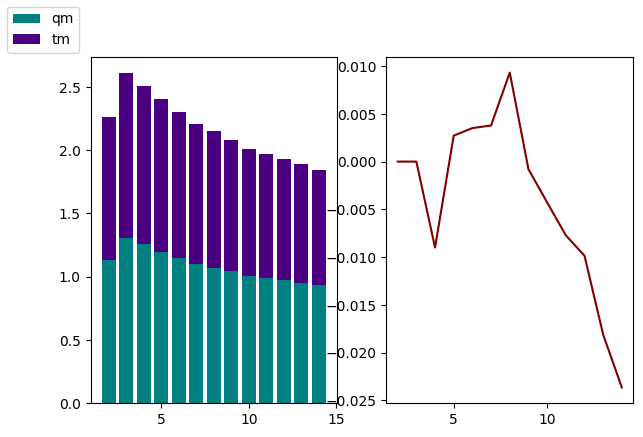

In [108]:
modified_b()

Recall that the distribution is based on a combination of one discrete random variable (the number of positions in a bushel of corn) and one continuous random variable, the price of corn, which according to the original workbook is a stochastic process

$P_{i} = P_{i - 1} + \sigma*\text{CDF}^{-1}(\text{N}(0, 1))$

and this stochastic process is nonlinear. Herein, I have other risk management methods to explore. The risk management could really go out of control if I decide to use my myomic parametric VaR across a portfolio of multiple assets.

There is a long distance between $0$ and $1$ whereas the distance between $0.00$ and $0.01$ is short, in comparison (short $\delta$ in a continuous distribution). Also, a complex situation such as this one, where there are multiple random variables determining what the result of the process is going to be in the end indeed warrants a fresh look into the array of sample collection and risk management methods available. These are:

1. VaR Relatives
    1. ~~Value at Risk (VaR)~~
    2. Conditional Value at Risk (CVaR) or Expected Shortfall
    3. Historical Value at Risk (VaR) method
    4. Expectile conditioned to a predictive VaR (CEVaR)
    5. Expectile conditioned to a realized VaR (CRVaR)
2. Other Testing Methods:
    1. Stress testing
    2. Scenario analysis
    3. Sharpe ratio
    4. Sortino ratio
    5. Monte Carlo Value at Risk (VaR) approach
    6. Other Representations of Expected Shortfall and Shortfall risk
    7. Managing otherwise painful pitfalls by using bootstrapping for survivability and long-term sustainability while making sure survorship bias is handled accordingly

There is not enough data to come up with a historical VaR, and I will need to learn more about the $\text{CEVaR}$ and $\text{CRVaR}$ methods before using them in practice. I can still take the Expected Shortfall, what is also called the Conditional Value at Risk ($\text{CVaR}$). I will be using in practice some of the other testing methods I highlighted above, but for this short exercise, $\text{CVaR}$ is good enough.

I have modified function `b` to take into account the tail-end of the distribution, with each positive change in the number of positions in the univariate portfolio of corn, The standard error of the variance is more accurately

$$
    se(s^2) = \sqrt{\frac{1}{n}\left( \mu_4 - \frac{n - 3}{n - 1}s^4 \right)}
$$

which is an exact formula, regardless of the distribution or sample size, from which I can get the standard error of the standard deviation as $\sqrt{\sigma^2}$. Note that

$\mu_4 = E(X - \mu)^4$.

There is no need to do this in practice. In fact, I can choose a sufficiently large sample, to obtain the parameter estimate for $\Theta = s^2$, the sample variance. My new approach takes me to the fourth section of the analysis, where I will analyze the quadratic, arithmetic, geometric and harmonic means as well as use the nearest percentile method for the boxplots. I will end my analysis with the $\text{CVaR}$ analysis.

## Fourth Section of the Analysis

In [110]:
import statistics as st
from scipy.stats import bootstrap as bt

Below is a brief recall of how I ended up generating position counts, using a binomial random variable. I am not running the code. This is just a brief recall.

```python
pos = [1]
countdown = 14

probs = np.random.binomial(n=10, p=(1/100)*np.transpose([37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03]))

i = 1
while countdown > 0:
    countdown -= 1
    pos.append(pos[i-1] + probs[i-1]); i += 1

pos

for i, x in enumerate(range(12, 27)):
    wb.Sheets(2).Cells(x, 4).Value = pos[i]
```

Note that I am not computing averaged resamples this time (which was an erroneous mistake of an earlier exercise due to the changing positions in the portfolio). I am simply adding $1,000$ resamples directly, as each of the $15$ cells in the margin calls has a different number of positions, some held, and new ones being added, following the probability vector under `probs`, as noted above.

### Hypothesis Testing for 5% Value at Risk

As before, I am assuming a $5\%$ value at risk at a $(1 - \alpha) = 95\%$ confidence level, which gives me how much money I will lose with $95\%$ confidence in a one-tailed test that is piece-wise defined as

$$
    \begin{cases}
        H_0 & \Theta \leq \Theta_0 \\
        H_a & \Theta \gt \Theta_0
    \end{cases}
$$

where $\Theta = r$ and $\Theta_0 = r_0$ for this example. Let us say the hypothesized value is $11\%$ return as before, or $r_0 = 0.11$. I can then calculate the t-statistic for the first order moment $r$, which is

$$
    t = \frac{\bar{r}-{r_0}}{s/\sqrt{n}}
$$

**01/28/2024 Note:** Value at risk may be inaccurate, because t-value testing does not work due to skewness in the data. The below code snippet is ran to keep a history of the work being done here.

In [198]:
ci_μ = []
ci_σ = []

eps = 1E-9

rng = np.random.default_rng()
for i, x in enumerate(X):
    ci_μ.append(list(np.round(np.multiply(pos[i], 
                                        bt((X.iloc[:, i],), 
                                        np.mean, 
                                        confidence_level=0.95, 
                                        alternative='greater', 
                                        random_state=rng, 
                                        method='percentile').confidence_interval), decimals=2)))
    ci_σ.append(list(np.round(np.multiply(pos[i], 
                                        bt((X.iloc[:, i],), 
                                        np.std,
                                        confidence_level=0.95, 
                                        alternative='greater', 
                                        random_state=rng, 
                                        method='percentile').confidence_interval), decimals=2)))

ci_μ = [ci_μ[i][0] for i in range(0, 15)]
ci_σ = [ci_σ[i][0] for i in range(0, 15)]

That is a lot better. Now, I identify the outliers, as I did before, except that I will be replacing the `midpoint` interpolation method with the `nearest` percentile method. [1]
1. Hydnman, R. J. & Yanan Fan. "Sample Quantiles in Statistical Packages." *The American Statistician*, Vol. 50, No. 4. (Nov., 1996), pp. 361-365.

In [128]:
m = parms['AM']
e = parms['SEM']

s = parms['STD'].copy(deep=True)
r = parms['r'].copy(deep=True)

q1_μ = np.percentile(x, 25, method='nearest')
q3_μ = np.percentile(x, 75, method='nearest')

q1_e = np.percentile(e, 25, method='nearest')
q3_e = np.percentile(e, 75, method='nearest')

q1_σ = np.percentile(s, 25, method='nearest')
q3_σ = np.percentile(s, 75, method='nearest')

q1_r = np.percentile(r, 25, method='nearest')
q3_r = np.percentile(r, 75, method='nearest')

iqr_μ = q3_μ-q1_μ;
iqr_e = q3_e-q1_e;
iqr_σ = q3_σ-q1_σ;
iqr_r = q3_r-q1_r;

outliers_μ = (np.mean(m) - 1.5*iqr_μ, np.mean(m) + 1.5*iqr_μ)
outliers_e = (np.mean(e) - 1.5*iqr_e, np.mean(e) + 1.5*iqr_e)
outliers_s = (np.mean(s) - 1.5*iqr_σ, np.mean(s) + 1.5*iqr_σ)
outliers_r = (np.mean(r) - 1.5*iqr_r, np.mean(r) + 1.5*iqr_r)

Winsorizing the parameters,

In [182]:
import warnings
warnings.filterwarnings('ignore')

for i, each in enumerate(m):
    if each < outliers_μ[0]:
        m[i] = outliers_μ[0];
    if each > outliers_μ[1]:
        m[i] = outliers_μ[1];

for i, each in enumerate(e):
    if each < outliers_e[0]:
        e[i] = outliers_e[0];
    if each > outliers_e[1]:
        e[i] = outliers_e[1];

for i, each in enumerate(σ):
    if each < outliers_σ[0]:
        s[i] = outliers_σ[0];
    if each > outliers_σ[1]:
        s[i] = outliers_σ[1];

for i, each in enumerate(r):
    if each < outliers_r[0]:
        r[i] = outliers_r[0];
    if each > outliers_r[1]:
        r[i] = outliers_r[1];

and replotting to obtain

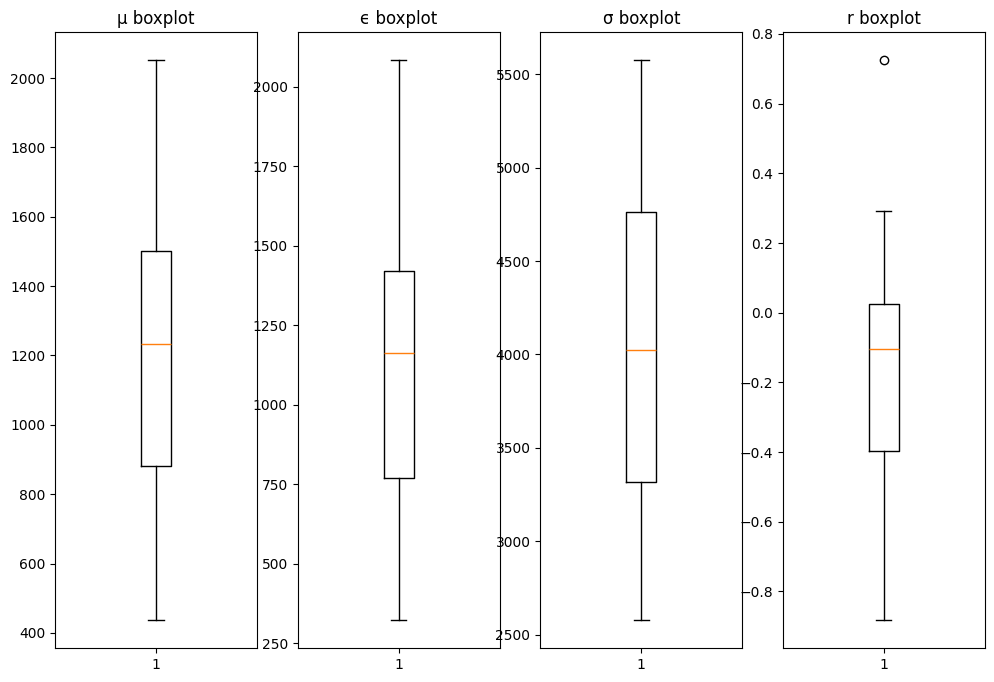

In [183]:
o(m, e, s, r[2:])

There is skewness in the margin call returns. After running these calculated statistics, I can retrieve the standard error of the margin call returns (with outliers removed) and have a calculated $t$-statistic for each of the $14$ returns (there are $15$ margin calls listed, for which I generate $14$ returns).

In [138]:
from scipy.stats import t

r = parms['r'][1:]
t = np.abs((r - 14*[0.11]) / t.ppf(0.95, df = 13)); t

1     1.106212
2     0.204371
3     0.560487
4     0.102685
5     0.116638
6     0.140846
7     0.327060
8     0.124990
9     0.346819
10    0.278877
11    0.107998
12    0.102105
13    0.097829
14    0.310522
Name: r, dtype: float64

None of the margin call returns fall within the rejection region ($t \gt 1.761$).

$\therefore$ I fail to reject $H_0$ in favor of the alternative hypothesis ($H_a$), or that $r \le r_0 = 0.11$ at the $95\%$ level. There is sufficient evidence to suggest that there is very little volatility in the mean return for the "buy and hold" strategy with binomial decisions following probability vector

$$
    P = \frac{1}{100}(37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03)^t
$$

as done above, with binomial decisions $\{\text{"buy"}, \text{"hold"}\}$.

Below, I calculate arithmetic (`am`) and geometric (`gm`) means, to obtain mean differences, denoting volatility in the simulated futures market with one asset; namely, corn (maize).

### Quadratic Mean ($\text{QM}$), Arithmetic Mean ($\text{AM}$), Geometric Mean ($\text{GM}$) and Arithmetic-Geometric Mean ($\text{AGM}$) Differences of Margin Call Log-Returns

The relation between $\text{QM}$, $\text{AM}$, $\text{GM}$ and $\text{HM}$ is $\text{QM} \ge \text{AM} \ge \text{GM} \ge \text{HM}$, with $\text{AM} \times \text{HM} = \text{GM}^2$.

Then, I have that the geometric mean $\text{GM} = \sqrt[n]{\prod{r_i}}$ is a number in the real interval

$$
    [\text{HM}, \text{AM}] = \left[ \frac{n}{\frac{1}{r_1}+\frac{1}{r_2}+\cdots+\frac{1}{r_n}}, \frac{r_1+r_2+\cdots+r_n}{n} \right]
$$

with all three means being equal when there is no asset price change, or a change in the margin call from one day to the next, as in the case of a futures contract on bushels of maize (corn). Another way to express the geometric mean is:

$$
    \text{GM} = \sqrt[n]{\left( \prod_{i=1}^n r_i \right)} = \exp{ \left[ \frac{1}{n}\sum_{i=1}^n\ln{(1 + R_i)} \right] } = \exp{ \left[ \frac{1}{n}\sum_{i=1}^n\ln{(r_i)} \right] } \tag{1}
$$

where $R_i$ is an expression for the simple returns, and this is a more efficient way of expressing the same, due to several products being replaced by one exponential of an arithmetic mean of log returns.

1. [Geometric mean](en.wikipedia.org/wiki/Geometric_mean)

To cap it all off, I then have the quadratic mean of log returns, which is equal to

$$
    \text{QM} = \sqrt{\frac{1}{n}\sum_{i=1}^n\ln{\left(\frac{r_i}{r_{i-1}}\right)^2}}
$$

I cannot plot the harmonics, due to negative log returns. Also, there is nonzero skewness in the log returns, which alters the relation above, where $\text{QM} \ge \text{AM} \ge \text{GM} \ge \text{HM}$, but I have the following graphics for illustration of the problem at hand:

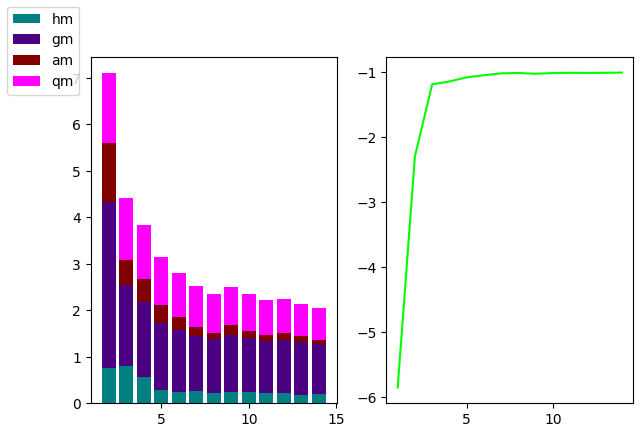

In [176]:
sp_r = parms['R']
lg_r = parms['r']
M_ct = parms['MAX']

am = []
gm = []
hm = []
qm = []

color1 = 'teal'
color2 = 'indigo'
color3 = 'maroon'
color4 = 'magenta'
color5 = 'lime'

eps = 1e-9
n = [i for i in range(1, 15)]

# assume simple returns for below function
def log_returns(x):
    return np.log(1 + x)

# assume log returns for below functions
def quad_mean(x):
    return np.sqrt(np.mean(np.square(x)))

def arith_mean(x):
    return np.mean(x)

def geom_mean(x):
    return np.exp(np.mean(x))

def harm_mean(x):
    return st.harmonic_mean(np.abs(x))

window = 14
qm = lg_r.rolling(window, min_periods=1).apply(quad_mean)

window = 14
am = lg_r.rolling(window, min_periods=1).apply(arith_mean)

window = 14
gm = lg_r.rolling(window, min_periods=1).apply(geom_mean)

window = 14
hm = lg_r[1:].rolling(window, min_periods=2).apply(harm_mean)

dz = pd.DataFrame({
    'qm': qm,
    'am': am,
    'gm': gm,
    'hm': hm
})

fig, axs = plt.subplots(1, 2)

axs[0].bar(dz['hm'].index[1:], hm, label='hm', color=color1)
axs[0].bar(dz['gm'].index, gm, bottom=dz['hm'], label='gm', color=color2)
axs[0].bar(dz['am'].index, am, bottom=dz['hm']+dz['gm'], label='am', color=color3)
axs[0].bar(dz['qm'].index, qm, bottom=dz['hm']+dz['gm']+dz['am'], label='qm', color=color4)

axs[1].plot(np.subtract(am, gm), color=color5)

fig.set_size_inches(7, 4.5)
fig.legend(loc='upper left')

which indicate that the geometric mean starts high and then decreases, but it never gets to a value lower than the quadratic; this breaks the relation I am supposed to obtain. The varying skewness that is still present in the simulation, despite removing outliers, is presenting a problem. The parameters are inaccurate, which means that all statistical moments are inaccurate, as well as their respective standard errors.

Also, note that I took the absolute value of the harmonic mean, because I was obtaining negative harmonics. This is not best practice. The relation:

$\text{QM} \geq \text{AM} \geq \text{GM} \geq \text{HM}$ only works when the distrubtion is approximately normal, or t-distributed with fat tails, but any skewness in the data breaks this important relation.

Now I take a look into the $\text{CVaR}$ case.

### The $\text{CVaR}$ Case

Something I learned earlier that may be important to rehearse herein is what is called the **conditional probability**, which is

$P(A | B) = P(AB) / P(B), P(B) \neq 0$

where the conditional probability $P(A | B)$ is the quotient of the joint probability $P(AB)$ and the marginal probability $P(B)$. Note that this way of expressing the conditional probability is different from Bayes' Theorem:

$P(A | B) = \frac{P(B | A)}{P(B)}P(A)$

although these are related in that one can use Bayes' Theorem in order to generate a conditional probability.

Suppose that you as an analyst working for a big bank are an oracle with a crystal glass, and you know exactly what my decisions are going to be, based on probability vector

$$
    P = \frac{1}{100}(37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03)^t
$$

for which you made the following probability table of expected profit for an institution holding several commodity contracts I have with the bank, although the explicit focus here is on corn:

In [203]:
from IPython.display import Markdown as md

md( "row | positions               | positive margin calls           | probability of event  | expected profit for broker / losses for contractee " + "\r"
    "--- | ----------------------- | ------------------------------- | ----------------------|----------------------------------------------------" + "\r"
    "000 | {}".format(pos[0])  + " | {}".format(parms['%>0'][0]) + " | {}".format(np.nan)+ " | 0                                                  " + "\r"
    "001 | {}".format(pos[1])  + " | {}".format(parms['%>0'][1]) + " | 37.00/100 = 37.00%    | {}".format(ci_μ[1] + ci_σ[1])                        + "\r"
    "002 | {}".format(pos[2])  + " | {}".format(parms['%>0'][2]) + " | 19.00/100 = 19.00%    | {}".format(dg['ci_σ'][2])                       + "\r"
    "003 | {}".format(pos[3])  + " | {}".format(parms['%>0'][3]) + " | 17.00/100 = 17.00%    | {}".format(dg['ci_σ'][3])                       + "\r"
    "004 | {}".format(pos[4])  + " | {}".format(parms['%>0'][4]) + " | 11.00/100 = 11.00%    | {}".format(dg['ci_σ'][4])                       + "\r"
    "005 | {}".format(pos[5])  + " | {}".format(parms['%>0'][5]) + " | 00.07/100 = 07.00%    | {}".format(dg['ci_σ'][5])                       + "\r"
    "006 | {}".format(pos[6])  + " | {}".format(parms['%>0'][6]) + " | 01.70/100 = 01.70%    | {}".format(dg['ci_σ'][6])                       + "\r"
    "007 | {}".format(pos[7])  + " | {}".format(parms['%>0'][7]) + " | 01.50/100 = 01.50%    | {}".format(dg['ci_σ'][7])                       + "\r"
    "008 | {}".format(pos[8])  + " | {}".format(parms['%>0'][8]) + " | 01.50/100 = 01.50%    | {}".format(dg['ci_σ'][8])                       + "\r"
    "009 | {}".format(pos[9])  + " | {}".format(parms['%>0'][9]) + " | 01.30/100 = 01.30%    | {}".format(dg['ci_σ'][9])                       + "\r"
    "010 | {}".format(pos[10]) + " | {}".format(parms['%>0'][10])+ " | 01.20/100 = 01.20%    | {}".format(dg['ci_σ'][10])                      + "\r"
    "011 | {}".format(pos[11]) + " | {}".format(parms['%>0'][11])+ " | 01.00/100 = 01.00%    | {}".format(dg['ci_σ'][11])                      + "\r"
    "012 | {}".format(pos[12]) + " | {}".format(parms['%>0'][12])+ " | 00.70/100 = 00.70%    | {}".format(dg['ci_σ'][12])                      + "\r"
    "013 | {}".format(pos[13]) + " | {}".format(parms['%>0'][13])+ " | 00.07/100 = 00.07%    | {}".format(dg['ci_σ'][13])                      + "\r"
    "014 | {}".format(pos[14]) + " | {}".format(parms['%>0'][14])+ " | 01.00/100 = 00.03%    | {}".format(dg['ci_σ'][14][0])                   + "\r"
)

row | positions               | positive margin calls           | probability of event  | expected profit for broker / losses for contractee --- | ----------------------- | ------------------------------- | ----------------------|----------------------------------------------------000 | 1 | 0.295 | nan | 0                                                  001 | 6 | 0.231 | 37.00/100 = 37.00%    | 3870.95002 | 8 | 0.208 | 19.00/100 = 19.00%    | [289461.32, inf]003 | 9 | 0.144 | 17.00/100 = 17.00%    | [367397.11, inf]004 | 10 | 0.153 | 11.00/100 = 11.00%    | [360199.92, inf]005 | 10 | 0.166 | 00.07/100 = 07.00%    | [371594.23, inf]006 | 10 | 0.115 | 01.70/100 = 01.70%    | [355534.82, inf]007 | 10 | 0.121 | 01.50/100 = 01.50%    | [361829.95, inf]008 | 10 | 0.106 | 01.50/100 = 01.50%    | [321443.27, inf]009 | 10 | 0.116 | 01.30/100 = 01.30%    | [314520.73, inf]010 | 10 | 0.104 | 01.20/100 = 01.20%    | [289248.13, inf]011 | 10 | 0.107 | 01.00/100 = 01.00%    | [286044.22, inf]012 | 10 | 0.088 | 00.70/100 = 00.70%    | [273703.59, inf]013 | 10 | 0.1 | 00.07/100 = 00.07%    | [299647.49, inf]014 | 10 | 0.086 | 01.00/100 = 00.03%    | 13641.17

Drawing plots for mean ($\mu$) and standard deviation ($\sigma$), similar to what I did earlier, except that boxplots are now replaced with Pareto plots.

In [136]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def modified_d(tm, qm):
    color1 = 'steelblue'
    color2 = 'red'
    line_size = 4
    
    fig, axs = plt.subplots(3, 3)
    axs[0, 0].hist(tm); axs[0, 0].set_title('tm pdf')
    axs[0, 1].hist(tm, cumulative=True); axs[0, 1].set_title('tm cdf')
    axs[0, 2].bar(tm.index, np.cumsum(tm), color=color1)
    axs[0, 2].plot(tm, color=color2, marker='D'); axs[0, 2].set_title('Tri-Mean Pareto')
    axs[0, 2].yaxis.set_major_formatter(PercentFormatter())
    axs[1, 0].hist(qm); axs[1, 0].set_title('qm pdf')
    axs[1, 1].hist(qm, cumulative=True); axs[1, 1].set_title('qm cdf')
    axs[1, 2].bar(qm.index, np.cumsum(qm), color=color1)
    axs[1, 2].plot(qm, color=color2, marker='D'); axs[1, 2].set_title('Quantile-Mean Pareto')
    axs[1, 2].yaxis.set_major_formatter(PercentFormatter())
    axs[2, 0].hist(tm-qm); axs[2, 0].set_title('tm-qm diff')
    axs[2, 1].hist(tm-qm, cumulative=True); axs[2, 1].set_title('tm-qm diff')
    axs[2, 2].bar(qm.index, np.cumsum(tm-qm), color=color1)
    axs[2, 2].plot(tm-qm, color=color2, marker='D'); axs[2, 2].set_title('TQ-Difference Pareto')
    axs[2, 2].yaxis.set_major_formatter(PercentFormatter())
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.set_size_inches(14, 9)

modified_d(tm, qm)

NameError: name 'tm' is not defined

I now have a more accurate illustration of what is going on. Note that the generated $\text{PDF}$ functions are negatively skewed for the log returns of margin calls and standard error of returns, which is good for the investor but not as good for the vested target. What I need is a conditional $\text{VaR}$ to obtain how much the vested target is expected to lose in the worst case (how much to gain in the best of all worlds for the investor); for this reason, I have decided to use the maximum for each of the $15$ days in the sampling distribution of margin calls for the $\text{CVaR}$ case, which has more focus on the tail-ends of the distribution.

Keeping the standard error based on the margin call sampling distribution, I compute the log returns using the maximum, where I have

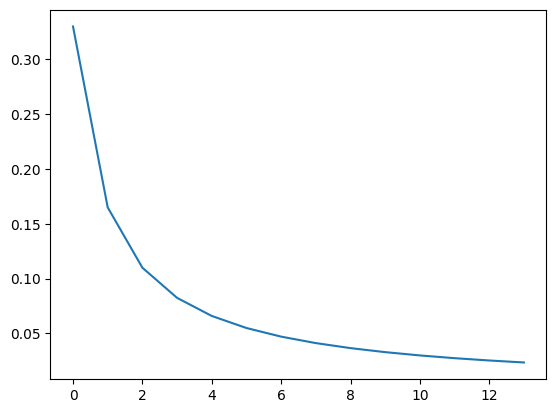

In [140]:
import numpy as np
import matplotlib.pyplot as plt

n = len(dg['M_ct'])

sp_r = pd.Series(dx['sp_r'])
lg_r = pd.Series(np.log(np.ones(n-1)+sp_r))

window = 14 # define a rolling window size

def trig_mean(x):
    pos = lg_r[lg_r > 0] # filter positive
    w = len(pos) / len(x) # proportion of positive log returns
    g = np.exp(np.mean(np.log(pos))) # geometric mean of pos log returns
    return w * g + (1 - w) * 0

trig_mean_returns = sp_r.rolling(window, min_periods=1).apply(trig_mean)

plt.plot(trig_mean_returns)

## TODO

1. Continue working on the Expected Shortfall ($\text{CVaR}$) case above.
2. Dive further into the Brownian motion within the random walk $P_i = P_{i-1} + \sigma*\text{CDF}^{-1}{N(0, 1)}$, exploring possible alternative models for a lognomral distribution of returns with positive skewness.
3. Consider using Bayes' theorem for conditional expected value.